# Exercice 1 - Airline pricing model

One flight per day From Boston to Atlanta / 150 people
Three prices pi (i=1,2,3)

* category 1 : 14 days advance purchase
* category 2 : leisure travelers
* category 3 : business travelers

Demand : Di = ai*exp(-pi/ai), ai = (100, 150, 300), we estimate the Di functions are continuous
    

## Revenue maximization problem
Here the three demand functions can be understood as the number of seats of each category that will be provided.

So the revenue is the product of the price of one seat multiplied by the number of seats sold, for each category. So

**Revenue(p1,p2,p3)  = p1 * D1(p1) + p2 * D2(p2) + p3 * D3(p3)**

where 

* pi is the price of the seat for the category i
* Di the demande for category i, depending on pi

**So the formulation of the problem is :**

* Maximize the Revenue value (cost function) define just above
* we can assume that the universe search is for each pi (0, +infini(, even if in practice we will put a higher value to pi
* under the constraint : D1+D2+D3 = 150 : the number of seats are 150.



## Optimal prices and number of people expected in each category

### First let's have a look at demand function
* The three demans functions are decreasing from a to 0 when price vary from 0 to infinity
* The three curves crosses the horizontal line y=50 : That means that at least a "naive" solution exist to this problem where the number of allocated seats are the same for each category equal to 50.

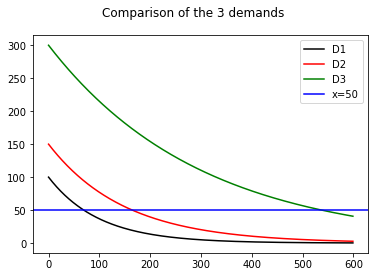

In [283]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

# function for the demande p and a are float of dimmention 3
def demande_Di(p,i):
    a = [100,150,300]
    return a[i]*math.exp(-p/a[i])

# definition on the three constant a1,a2,a3
# definition of the range of the graph
minMax = range(0,600)
plt.figure()
plt.suptitle("Comparison of the 3 demands ")
plt.plot([demande_Di(p,0) for p in minMax], 'k', label = 'D1')
plt.plot([demande_Di(p,1) for p in minMax], 'r', label = 'D2')
plt.plot([demande_Di(p,2) for p in minMax], 'g', label = 'D3')
plt.axhline(y=50,color="b", label = "x=50")
plt.legend(loc='upper right')
plt.show()

### Then let's have a look at the revenue function
As it is a 3 dimensionnal function, the visualisation in 4D is not possible, but we can have a look at the equivalent 2D function to this the revenue function in 3D
Revenue2D = p1 * D1 + p2 * D2


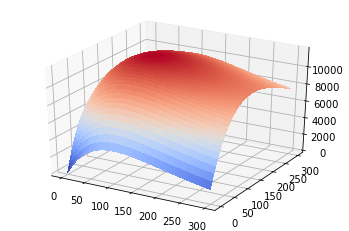

In [284]:
import numpy as np
from matplotlib import cm

def Revenue2D(p1,p2):
    a = [100,150,300]
    return p1*a[0]*np.exp(-p1/a[0]) + p2*a[1]*np.exp(-p2/a[1])

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
p1 = np.arange(0, 300, 1)
p2 = np.arange(0, 300, 1)
p1, p2 = np.meshgrid(p1, p2)
R = Revenue2D(p1,p2)

# Plot the surface.
surf = ax.plot_surface(p1, p2, R, cmap=cm.coolwarm, linewidth=0, antialiased=False)

In [285]:
from functools import partial
import numpy as np

def _obj_wrapper(func, args, kwargs, x):
    return func(x, *args, **kwargs)

def _is_feasible_wrapper(func, x):
    return np.all(func(x)>=0)

def _cons_none_wrapper(x):
    return np.array([0])

def _cons_ieqcons_wrapper(ieqcons, args, kwargs, x):
    return np.array([y(x, *args, **kwargs) for y in ieqcons])

def _cons_f_ieqcons_wrapper(f_ieqcons, args, kwargs, x):
    return np.array(f_ieqcons(x, *args, **kwargs))
    
def pso(func, lb, ub, ieqcons=[], f_ieqcons=None, args=(), kwargs={}, 
        swarmsize=100, omega=0.5, phip=0.5, phig=0.5, maxiter=100, 
        minstep=1e-8, minfunc=1e-8, debug=False, processes=1,
        particle_output=False):
    """
    Perform a particle swarm optimization (PSO)
   
    Parameters
    ==========
    func : function
        The function to be minimized
    lb : array
        The lower bounds of the design variable(s)
    ub : array
        The upper bounds of the design variable(s)
   
    Optional
    ========
    ieqcons : list
        A list of functions of length n such that ieqcons[j](x,*args) >= 0.0 in 
        a successfully optimized problem (Default: [])
    f_ieqcons : function
        Returns a 1-D array in which each element must be greater or equal 
        to 0.0 in a successfully optimized problem. If f_ieqcons is specified, 
        ieqcons is ignored (Default: None)
    args : tuple
        Additional arguments passed to objective and constraint functions
        (Default: empty tuple)
    kwargs : dict
        Additional keyword arguments passed to objective and constraint 
        functions (Default: empty dict)
    swarmsize : int
        The number of particles in the swarm (Default: 100)
    omega : scalar
        Particle velocity scaling factor (Default: 0.5)
    phip : scalar
        Scaling factor to search away from the particle's best known position
        (Default: 0.5)
    phig : scalar
        Scaling factor to search away from the swarm's best known position
        (Default: 0.5)
    maxiter : int
        The maximum number of iterations for the swarm to search (Default: 100)
    minstep : scalar
        The minimum stepsize of swarm's best position before the search
        terminates (Default: 1e-8)
    minfunc : scalar
        The minimum change of swarm's best objective value before the search
        terminates (Default: 1e-8)
    debug : boolean
        If True, progress statements will be displayed every iteration
        (Default: False)
    processes : int
        The number of processes to use to evaluate objective function and 
        constraints (default: 1)
    particle_output : boolean
        Whether to include the best per-particle position and the objective
        values at those.
   
    Returns
    =======
    g : array
        The swarm's best known position (optimal design)
    f : scalar
        The objective value at ``g``
    p : array
        The best known position per particle
    pf: arrray
        The objective values at each position in p
   
    """
   
    assert len(lb)==len(ub), 'Lower- and upper-bounds must be the same length'
    assert hasattr(func, '__call__'), 'Invalid function handle'
    lb = np.array(lb)
    ub = np.array(ub)
    assert np.all(ub>lb), 'All upper-bound values must be greater than lower-bound values'
   
    # EK : information on convergence:
    #   0 : no convergence / constraint not satisfied
    #   1 : convergence : no move for cost
    #   2 : convergence : no move for position
    #   3 : no convergence / constraint satisifed
    solution = 0
    objT =[]
    
    vhigh = np.abs(ub - lb)
    vlow = -vhigh

    # Initialize objective function
    obj = partial(_obj_wrapper, func, args, kwargs)
    
    # Check for constraint function(s) #########################################
    if f_ieqcons is None:
        if not len(ieqcons):
            if debug:
                print('No constraints given.')
            cons = _cons_none_wrapper
        else:
            if debug:
                print('Converting ieqcons to a single constraint function')
            cons = partial(_cons_ieqcons_wrapper, ieqcons, args, kwargs)
    else:
        if debug:
            print('Single constraint function given in f_ieqcons')
        cons = partial(_cons_f_ieqcons_wrapper, f_ieqcons, args, kwargs)
    is_feasible = partial(_is_feasible_wrapper, cons)

    # Initialize the multiprocessing module if necessary
    if processes > 1:
        import multiprocessing
        mp_pool = multiprocessing.Pool(processes)
        
    # Initialize the particle swarm ############################################
    S = swarmsize
    D = len(lb)  # the number of dimensions each particle has
    x = np.random.rand(S, D)  # particle positions
    v = np.zeros_like(x)  # particle velocities
    p = np.zeros_like(x)  # best particle positions
    fx = np.zeros(S)  # current particle function values
    fs = np.zeros(S, dtype=bool)  # feasibility of each particle
    fp = np.ones(S)*np.inf  # best particle function values
    g = []  # best swarm position
    fg = np.inf  # best swarm position starting value
    
    # Initialize the particle's position
    x = lb + x*(ub - lb)

    # Calculate objective and constraints for each particle
    if processes > 1:
        fx = np.array(mp_pool.map(obj, x))
        fs = np.array(mp_pool.map(is_feasible, x))
    else:
        for i in range(S):
            fx[i] = obj(x[i, :])
            fs[i] = is_feasible(x[i, :])
       
    # Store particle's best position (if constraints are satisfied)
    i_update = np.logical_and((fx < fp), fs)
    p[i_update, :] = x[i_update, :].copy()
    fp[i_update] = fx[i_update]

    # Update swarm's best position
    i_min = np.argmin(fp)
    if fp[i_min] < fg:
        fg = fp[i_min]
        g = p[i_min, :].copy()
    else:
        # At the start, there may not be any feasible starting point, so just
        # give it a temporary "best" point since it's likely to change
        g = x[0, :].copy()
       
    # Initialize the particle's velocity
    v = vlow + np.random.rand(S, D)*(vhigh - vlow)
       
    # Iterate until termination criterion met ##################################
    it = 1
    while it <= maxiter:
        rp = np.random.uniform(size=(S, D))
        rg = np.random.uniform(size=(S, D))

        # Update the particles velocities
        v = omega*v + phip*rp*(p - x) + phig*rg*(g - x)
        # Update the particles' positions
        x = x + v
        # Correct for bound violations
        maskl = x < lb
        masku = x > ub
        x = x*(~np.logical_or(maskl, masku)) + lb*maskl + ub*masku

        # Update objectives and constraints
        if processes > 1:
            fx = np.array(mp_pool.map(obj, x))
            fs = np.array(mp_pool.map(is_feasible, x))
        else:
            for i in range(S):
                fx[i] = obj(x[i, :])
                fs[i] = is_feasible(x[i, :])

        # Store particle's best position (if constraints are satisfied)
        i_update = np.logical_and((fx < fp), fs)
        p[i_update, :] = x[i_update, :].copy()
        fp[i_update] = fx[i_update]

        
        # Compare swarm's best position with global best position
        i_min = np.argmin(fp)
         # ek : store the cost value  of the best particle's best position
        objT.append(fp[i_min])
        if fp[i_min] < fg:
            if debug:
                print('New best for swarm at iteration {:}: {:} {:}'\
                    .format(it, p[i_min, :], fp[i_min]))

            p_min = p[i_min, :].copy()
            stepsize = np.sqrt(np.sum((g - p_min)**2))

            if np.abs(fg - fp[i_min]) <= minfunc:
                #print('Stopping search: Swarm best objective change less than {:}'.format(minfunc))
                if particle_output:
                    solution = 1
                    return p_min, fp[i_min], p, fp,solution, it,objT
                else:
                    solution = 1
                    return p_min, fp[i_min],solution, it,objT
            elif stepsize <= minstep:
                #print('Stopping search: Swarm best position change less than {:}'.format(minstep))
                if particle_output:
                    solution = 2
                    return p_min, fp[i_min], p, fp,solution, it,objT
                else:
                    solution = 2
                    return p_min, fp[i_min],solution, it,objT
            else:
                g = p_min.copy()
                fg = fp[i_min]

        if debug:
            print('Best after iteration {:}: {:} {:}'.format(it, g, fg))
        it += 1

    #print('Stopping search: maximum iterations reached --> {:}'.format(maxiter))
    
    if not is_feasible(g):
        #print("However, the optimization couldn't find a feasible design. Sorry")
        solution = 0
    if particle_output:
        solution = 3
        return g, fg, p, fp, solution, it,objT
    else:
        solution = 3
        return g, fg, solution, it, objT

### First test with PSO algorithm
I copy/paste the definition of the pso function from

https://github.com/tisimst/pyswarm/blob/master/pyswarm/pso.py 

And I slightly modify it to be able to remove and treat outup of the function regarding the reason why the iteration process was stopped. I also add new return values to be able to follow the convergence of the algorithm.

The PSO algorithm is adapted to continuous variable, quick and takes in account "natively" the ability to pass a constraint function. So I will use this algorithme.
for the implementation :

* the revenue function will be transform into "- Revenue", to be able to run the algorithm that only works for minimization
* the contraint function in PSO alogorithm are as : g(x) >=0. So I will transform : D1+D2+D3 <= 150 in : g(x) = -D1-D2-D3 +150 >= 0

I fix the lower price to 0 and the maximum price to 1750. At 1750€ even the Demand 3 is below 1 seat so there is no interest to test a bigger price then 1750€

I am looking for the parameters swarmsize and number of iteration.
First step : I fix the number of iteration to nbiter = 1000 and I increase the number of swarm and plot the cost function relatively to the swarmsize.

The graph shows that from a swarm size of 600 the finding of the minimum is stable
Analysing the result of the pso function we also get the information that the process stops each time before reaching the full number of iteration so we can deduce that 1000 iterations are enough

In [286]:
#from pyswarm import pso

def Revenue(p):
    a = [100.0,150.0,300.0]
    result = 0
    for i in range(3):
              result = result - p[i] * a[i] * math.exp(-p[i]/a[i])
    return result

def infcon(p):
    result = 147
    a = [100.0,150.0,300.0]
    for i in range(3):
              result = result - a[i] * math.exp(-p[i]/a[i])
    return result



Optimal Revenue 43494.68298993283, value of p1,p2,p3 [160.72246855 210.72215381 360.71290779], constraint : 150.00000000004607


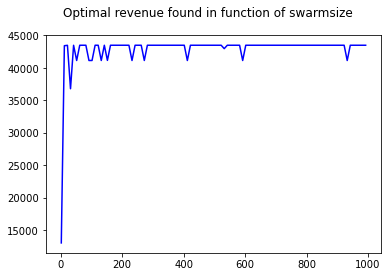

In [292]:
lb = [0.0]*3
ub = [1750.0]*3
cost = []
for i in range(2,1000,10):
    xopt, fopt,converge, nbiter,objT = pso(Revenue,lb,ub,swarmsize = i, maxiter = 1000,ieqcons=[infcon],debug=False,minstep=1e-10,minfunc=1e-10)
    cost.append(-fopt)

plt.figure()
plt.suptitle("Optimal revenue found in function of swarmsize")
plt.plot(range(2,1000,10),cost, 'b')
print("Optimal Revenue {0}, value of p1,p2,p3 {1}, constraint : {2}".format(-fopt,xopt,infcon(xopt)+150))

### Then I run PSO with swarmsize = 600 and iteration = 1000, 100 times to see if there are changes in the optimal result

Optimal Revenue : mean 43343.850187942975, max 41142.25950063026, min 43494.68298887, std dev 556.2854615962195


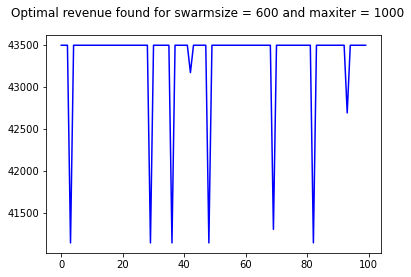

In [282]:
lb = [0.0]*3
ub = [1750.0]*3
cost = []
for i in range(100):
    xopt, fopt,converge, nbiter,objT = pso(Revenue,lb,ub,swarmsize = 600, maxiter = 1000,ieqcons=[infcon],debug=False,minstep=1e-10,minfunc=1e-10)
    cost.append(-fopt)

plt.figure()
plt.suptitle("Optimal revenue found for swarmsize = 600 and maxiter = 1000")
plt.plot(range(100),cost, 'b')

print("Optimal Revenue : mean {0}, max {1}, min {2}, std dev {3}".format(np.array(cost).mean(), \
                                                                  np.array(cost).min(),np.array(cost).max(),np.array(cost).std()))


### So the optimal revenue is 43494,68

I know try to found the best value so that the number of seats are integer values.

In [289]:
def price(Di,a):
    return -math.log(Di/a)*a
def demande(p,a):
    return a*math.exp(-p/a)

In [291]:
seat_th = (demande(xopt[0],100),demande(xopt[1],150),demande(xopt[2],300))
seat1=(20,21)
seat2=(37,38)
seat3=(91,92)
for i in range(2):
    for j in range(2):
        for k in range(2):
            lprice=(price(seat1[i],100),price(seat2[j],150),price(seat3[k],300))
            print (-Revenue(lprice),np.round(lprice,4),seat1[i],seat2[j],seat3[k],seat1[i]+seat2[j]+seat3[k])
print(lprice)


43554.10432213126 [160.9438 209.9576 357.8769] 20 37 91 148
43610.33886588461 [160.9438 209.9576 354.5982] 20 37 92 149
43612.05292098074 [160.9438 205.9574 357.8769] 20 38 91 149
43668.287464734094 [160.9438 205.9574 354.5982] 20 38 92 150
43612.588768618865 [156.0648 209.9576 357.8769] 21 37 91 149
43668.82331237222 [156.0648 209.9576 354.5982] 21 37 92 150
43670.53736746835 [156.0648 205.9574 357.8769] 21 38 91 150
43726.7719112217 [156.0648 205.9574 354.5982] 21 38 92 151
(156.06477482646685, 205.95737015548048, 354.59816928214826)


So we see that the optimal revenue with interger values for seats number and with number of seats <= 150 is :

* **cat1 : 21 seats (156,06€), cat2 : 38 sets(205,96€), cat3: 91 seats (357,88€) and a Revenue of 43670,54 €**

## Sensitivity analysis
remove 3 seats <=> number maximum of seats = 147 seats.
As a first approximation we could say that using the previous result a good decision would be to remove the three seats from cat 1 which is the less profitable categorie. Doing so the result would be :

* **cat1 : 18 seats (171,48€- new price related to D1), cat2 : 38 sets(205,96€), cat3: 91 seats (357,88€) and a Revenue of 43479 €**

But when running the simulation again with a constraint to 147 seats max, another optimum is found with the following result :

* **cat1 : 20 seats (160,94€), cat2 : 37 sets(209,96€€), cat3: 90 seats (361,19€€) and a Revenue of 43494,57€**

In [293]:
seat_th = (demande(xopt[0],100),demande(xopt[1],150),demande(xopt[2],300))
seat1=(20,21)
seat2=(36,37)
seat3=(90,91)
for i in range(2):
    for j in range(2):
        for k in range(2):
            lprice=(price(seat1[i],100),price(seat2[j],150),price(seat3[k],300))
            #print (lprice)
            print (-Revenue(lprice),np.round(lprice),seat1[i],seat2[j],seat3[k],seat1[i]+seat2[j]+seat3[k])
print(lprice)

43432.56986212527 [161. 214. 361.] 20 36 90 146
43492.10117552927 [161. 214. 358.] 20 36 91 147
43494.57300872725 [161. 210. 361.] 20 37 90 147
43554.10432213126 [161. 210. 358.] 20 37 91 148
43491.05430861287 [156. 214. 361.] 21 36 90 147
43550.58562201688 [156. 214. 358.] 21 36 91 148
43553.057455214854 [156. 210. 361.] 21 37 90 148
43612.588768618865 [156. 210. 358.] 21 37 91 149
(156.06477482646685, 209.95760721780468, 357.8768904418053)


# Ex2. Banana Function - with Gradient
Minimize f(x) = 100 * ( x2-x1^2 )^2 + (1-x1)^2, x1 and x2 belongs to K = [-5,5]

### First, have a look at the function



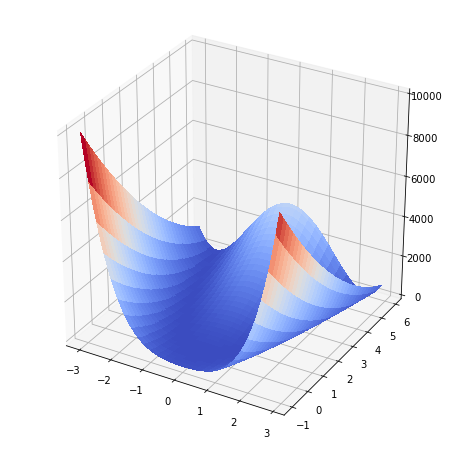

In [4]:
import numpy as np
from matplotlib import cm

def BananaVisu(x1,x2):
    return 100*(x2-x1**2)**2+(1-x1)**2

fig = plt.figure(figsize = (8,8))

ax = fig.gca(projection='3d')
x1 = np.arange(-3, 3, 0.1)
x2 = np.arange(-1, 6, 0.1)
x1,x2 = np.meshgrid(x1, x2)
B = BananaVisu(x1,x2)
surf = ax.plot_surface(x1, x2, B, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()


### Minimum ?
* K <> empty set, and K is closed
* f is continuous and infinite at infinity
So it exists at least 1 minimum on K

But looking at the first graph we are sure that the function is not convex

So no insurance regarding the convergence of the gradient method and no real information regarding optimal values for the rho parameter of the gradient.

### Minimize the function using a gradient method
As asked, I will use a gradient method that I progam in Python below : The fix step Gradient Method

For this, calculation of gradient :

    * dJ/dx1=-400x1(x2-x1^2) - 2 (1-x1)
    * dJ/dx2= 200(x2-x1^2)
    
There is no "real" constraint but the search univers is limited to (-5,5) for each variables.

I choose to take in account this restricted universe using a "clap" function that realize a projection on the search universe when the design variables goes out of this search universe.

### Process I followed

1) I first start applying the gradient method with different starting point. I rapidly understand that the "good" Rho parameter depends a lot on the starting position and that it was also the case for the number of iteration to realize to achieve a good convergence.

In particular if rho is too big : the algorithm do not converges and the x values get trapped in the border of the search universe, if rho is too small the algorithm is very slow to converge.

2) So I decided to improve my algorithm and to go for a "gradient optimal step" method in order to adjust the Rho parameter to the step values. 
I give up this idea because the Rho parameter seems to converge to 0 which has no interest. I not fully understand this but I plot a graph of the function to optimize in Rho for a particular x value (see below) and it seems to confirm this.

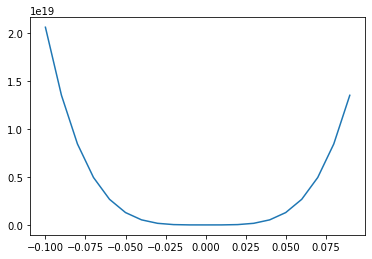

In [421]:
def J(x): 
    return 100*(x[1]-x[0]**2)**2+(1-x[0])**2

def grad(x):
    return np.array([-400*x[0]*(x[1]-x[0]**2)-2*(1-x[0]),200*(x[1]-x[0]**2)])

x0=np.array([1.2,-3])
grad1=grad(x0)
courbe = []
nbpoint = []
for tau in range (-10,10):
    nbpoint.append(tau/100)
    courbe.append(J(x0-tau*grad1))
plt.plot(nbpoint,courbe)
plt.show()


3) So I decide to optimize my alogrithm by calling the fix step gradient with successiv decreasing values of Rho, till the Gradient converge. 

This is my final step

### Implementation of my "fix step Gradient called with decreasing values of Rho"

My idea was to pick randomly 1000 points in the search universe and to try to tune my algorithm so that it converges for most of the points and to analyse the datas given by this algorithm.

I spent quite a lot of time to tune this algorithm in particular to find the right :

* stop criteria : I finally choose the "cost function" stability with a tolerance of 1e-08
* initial rho value : I found that above Rho = 0.001 the Gradient almost never converge whatever is the starting point
* the number of time the Rho parameter is decreased
* factor of decrease for Rho. I found that 1.4 is a good trade-off
* maximum number of iteration before giving up : I found that 140000 enables to find most optimum values

In [354]:
# Load library
import numpy as np



def clap(x,xmin,xmax):
    rclap1 = False
    rclap2 = False
    for i in range(len(x)):
        if x[i] < xmin[i] : 
            x[i]=xmin[i]
            rclap1 = True
        elif x[i] > xmax[i] :
            rclap2 = True
            x[i]=xmax[i]
    return rclap1 and rclap2
            
def gradRho(x,rho,grad):
    return (100*2*((x[1]-rho*grad[1])-(x[0]-rho*grad[0])**2)*(-grad[1]+2*(x[0]-rho*grad[0])*grad[0]) \
                   +2*(1-(x[0]-rho*grad[0]))*grad[0])
    
def see_ex2and3Result(x0,xOpt,JOpt, result,i,convergence,rho,nbiter):
    title =  " Fig. " + str(i+1) + " Convergence : " + str(convergence) + "\n x0 = " + str(np.around(x0,4)) + ", xopt = " \
    + str(np.around(xOpt,5)) +"\n , rho = "+ str(np.around(rho,6))+ ", #iter="+ str(nbiter) \
    +", CostFinal = " + str(np.around(JOpt,6))
    plt.axis([0,len(result),0,20])
    plt.subplot(3,3,i+1)
    plt.title(title)
    plt.plot(result)



In [355]:
# gradiant algo fix step
def gradientFixStep(x0,rho,nbiter,Bmin,Bmax,toleranceX):
    x = x0
    convergence = False
    result = []
    compt = nbiter
    deltaW =1
    Jxold = 0
    while abs(deltaW) > toleranceX and compt > 0:
        compt = compt -1
        deltaX = rho * grad(x)
        x = x - deltaX
        if clap(x,Bmin,Bmax) : compt = 0         
        Jx = J(x)
        result.append(Jx)
        deltaW=Jx-Jxold
        Jxold=Jx
    if abs(deltaW) <= toleranceX:
        convergence = True
    return convergence,x,J(x),result,nbiter-compt

# gradiant algo optimal step
def gradientOptimalStep(x0,rho,nbiter,Bmin,Bmax):
    x = x0
    rho2 = 0.01
    result = []
    for n in range(nbiter):
        gr = grad(x)
        pk = rho
        Jx=J(x)
        deltapk = 1
        boucle = 0
        clap(x,Bmin,Bmax)
        while (deltapk > 1e-04) and (boucle < 100):
            boucle = boucle + 1
            grho= gradRho(x,pk,gr)
            deltapk = rho2 * gradRho(x,pk,gr)
            pk = pk - deltapk
        x = x - pk * gr
        result.append(Jx)
    return x,J(x),result

In [356]:
# function searchRho search for the bigger rho achieving convergence (if possible convergence) and 
# return the found rho, convergence status, the number of iteration used, the achieved cost, the achieve otpimal
def searchRho(x0,rho0,Bmin,Bmax,nbitermax,tolerance):
    convergence = False
    loop = 50
    while    not convergence and loop > 0:
        convergence,xOpt,JOpt, result,nbiter = gradientFixStep(x0,rho0,nbitermax,Bmin,Bmax,tolerance)
        rho0 = rho0 / 1.4
        loop = loop -1
    return rho0,convergence,nbiter,JOpt,xOpt,result

### Convergence graph for 9 starting point choosen randomly over 1000 test runs

I have plotted above 9  graph with objective value on y-axis and iteration number on x-axis

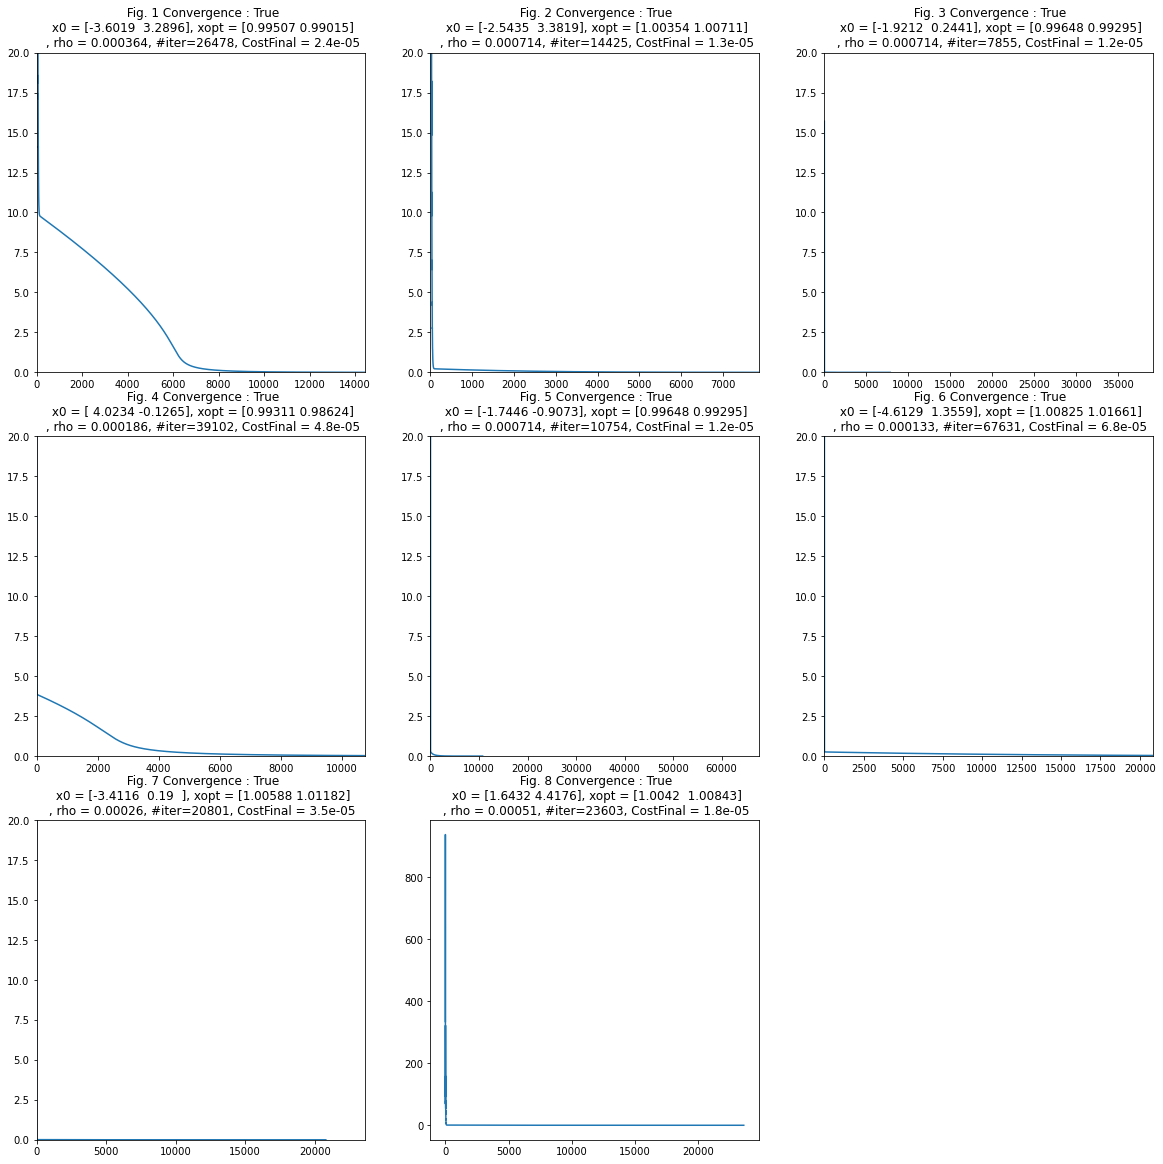

In [357]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy.random as rn
import time

nbinitPoint = 1000
x0 = [0.0,0.0]
Bmin=[-5,-5] # minimal bound
Bmax=[5,5]  # maximal bound
x =np.zeros(nbinitPoint)
y =np.zeros(nbinitPoint)
rhoT =np.zeros(nbinitPoint)
convergenceT = np.zeros(nbinitPoint)
nbiterT = np.zeros(nbinitPoint)
JOptT= np.zeros(nbinitPoint)
timeT=np.zeros(nbinitPoint)
rho0 = 0.001 # initialisation of the step value
nbitermax = 140000 # fixe number of iteration
tolerance = 1e-08 # tolerance value for stop criterion on changing value of cost function
plt.figure(figsize=(20,20))
for i in range(nbinitPoint):
    nbCallJcost = 0
    nbCallGrad = 0
    x0[0] = rn.random_sample()*10-5
    x0[1] = rn.random_sample()*10-5
    x[i]=x0[0]
    y[i]=x0[1]
    start = time.time()
    rho,convergence,nbiter,JOpt,xOpt,result = searchRho(x0,rho0,Bmin,Bmax,nbitermax,tolerance)
    end = time.time()
    rhoT[i]=rho
    convergenceT[i]=convergence
    nbiterT[i]=nbiter
    timeT[i]=end-start
    
    JOptT[i]=JOpt
    if (i % (nbinitPoint//8)) == 0:
        see_ex2and3Result(x0,xOpt,JOpt, result,i // (nbinitPoint//8),convergence,rho,nbiter)


### Result of the 1000 sample starting points test convergence

We can see that the convergence works for the whole 1000 starting points.

In [360]:
print("Convergence : {0} convergences over {1}".format(sum(convergenceT),nbinitPoint))
print("\nRho : \t\t minimum {0}, \t maximum {1}, \t mean {2}".format(np.round(min(rhoT),6),np.around(np.max(rhoT),6),np.around(np.mean(rhoT),6)))
print("Iter. number : \t minimum {0}, \t maximum {1}, \t mean {2}".format(min(nbiterT),np.max(nbiterT), \
                                                                                np.mean(nbiterT)))
print("Obj. value : \t minimum {0}, \t maximum {1},\t mean {2}".format(np.around(min(JOptT),6),np.around(np.max(JOptT),6),np.around(np.mean(JOptT),6)))     
print("Exec. time. : \t minimum {0}ms,\t maximum {1}ms, \t mean {2}ms".format(round(min(timeT)*1000,1), \
                                                                round(np.max(timeT)*1000,1),round(np.mean(timeT)*1000,1)))
      

Convergence : 1000.0 convergences over 1000

Rho : 		 minimum 0.000133, 	 maximum 0.000714, 	 mean 0.000474
Iter. number : 	 minimum 796.0, 	 maximum 102057.0, 	 mean 24577.959
Obj. value : 	 minimum 1.2e-05, 	 maximum 6.8e-05,	 mean 2.7e-05
Exec. time. : 	 minimum 11.7ms,	 maximum 1534.0ms, 	 mean 338.3ms


I found also intersting to see where on the search universe the iteration number is high and where it is low, same for the execution time and the rho number found

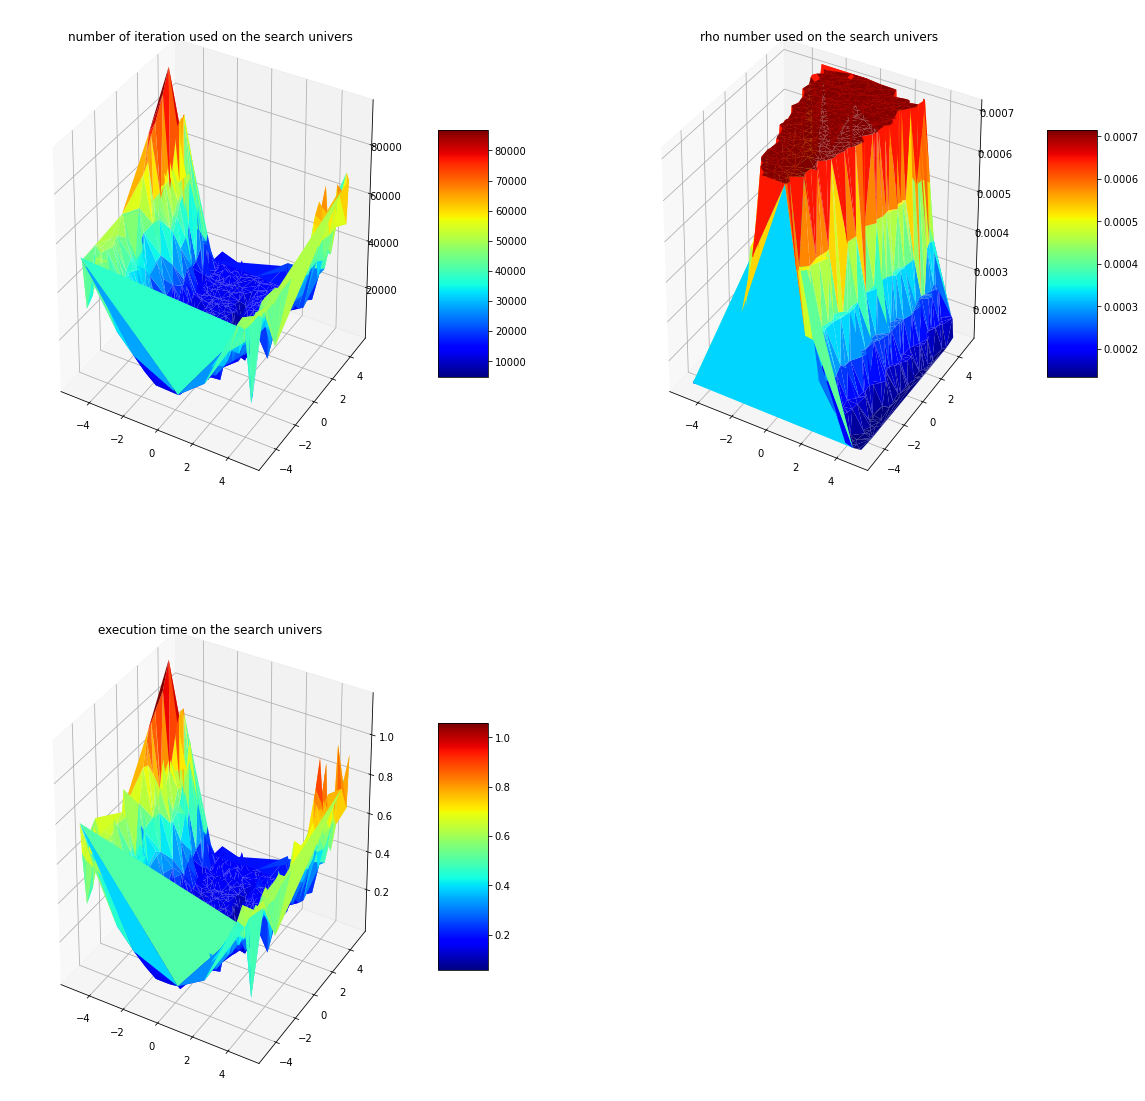

In [302]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(221, projection='3d')
surf = ax.plot_trisurf(x, y, nbiterT, cmap=cm.jet, linewidth=0.1)
plt.title("number of iteration used on the search univers")
fig.colorbar(surf, shrink=0.5, aspect=5)
ax2 = fig.add_subplot(222, projection='3d')
surf2 = ax2.plot_trisurf(x, y, rhoT, cmap=cm.jet, linewidth=0.1)
plt.title("rho number used on the search univers")
fig.colorbar(surf2, shrink=0.5, aspect=5)
ax3 = fig.add_subplot(223, projection='3d')
surf3 = ax3.plot_trisurf(x, y, timeT, cmap=cm.jet, linewidth=0.1)
plt.title("execution time on the search univers")
fig.colorbar(surf3, shrink=0.5, aspect=5)
plt.show()

**It is interesting to notice here that the region "around" the x2-axis (x1 close to 0) needs low iteration, high rho number and a small execution time**


# Ex2. Eggcrate Function - Gradient method

Minimize f(x) = x1^2 + x2^2 + 25*((sin(x1))^2 + (sin(x2))^2), x1 and x2 belongs to K = [-2*PI,2*PI]

### Minimum ?

* K <> empty set, and K is closed
* f is continuous and infinite at infinity
So it exists at least 1 minimum on K

The convexity of f is not obvious


### First let's have a look at the function
We can see that there are a lot of local optimal



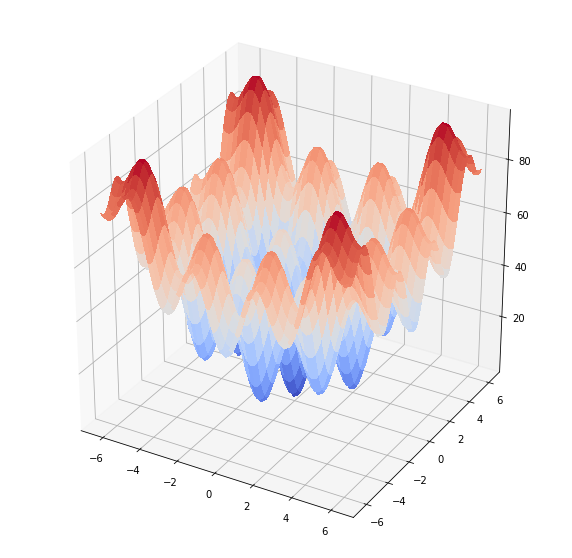

In [303]:
import numpy as np
from matplotlib import cm

def EggCrate(x1,x2):
    return x1**2+x2**2+25*((np.sin(x1))**2+(np.sin(x2))**2)

fig = plt.figure(figsize = (10,10))

ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-2*math.pi, 2*math.pi, 0.1)
Y = np.arange(-2*math.pi, 2*math.pi, 0.1)
X, Y = np.meshgrid(X, Y)
Z = EggCrate(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

A lot of local minimum means that if the starting point is far from the optimal point the global minimum can't be reached by a gradiet method. Only one of the local optimal will be reached.


### Minimize the function using a gradient method

There is no "real" constraint but the search univers is limited to (-2*PI,2*PI) for each variables.

I choose to take in account this restricted universe using a "clap" function that realize a projection on the search universe when the design variables goes out of this search universe.

### Process I follow

Here, in a way it is easier to apply "fix gradient method" because the same Rho can work every where on the search universe.

But what is interesting to find and to show is that the global optima can't be reach form all the points of the search universe.

To show this I use the same functions as before with Banana function but I will try to find different optimal (local and global)

In [361]:
def J(x):
    global nbCallJcost
    nbCallJcost = nbCallJcost + 1
    return x[0]**2+x[1]**2+25*((math.sin(x[0]))**2+(math.sin(x[1]))**2)

def grad(x):
    global nbCallGrad
    nbCallGrad=nbCallGrad+1
    return np.array([2*x[0]+50*math.sin(x[0])*math.cos(x[0]),2*x[1]+50*math.sin(x[1])*math.cos(x[1])])

def see_EggResult(x0,xOpt,JOpt, result,i,convergence,rho,nbiter):
    title =  " Fig. " + str(i+1) + " Convergence : " + str(convergence) + "\n x0 = " + str(np.around(x0,4)) + ", xopt = " \
    + str(np.around(xOpt,5)) +"\n , rho = "+ str(np.around(rho,6))+ ", #iter="+ str(nbiter) \
    +", CostFinal = " + str(np.around(JOpt,6))
    plt.subplot(3,3,i+1)
    plt.title(title)
    plt.plot(result)


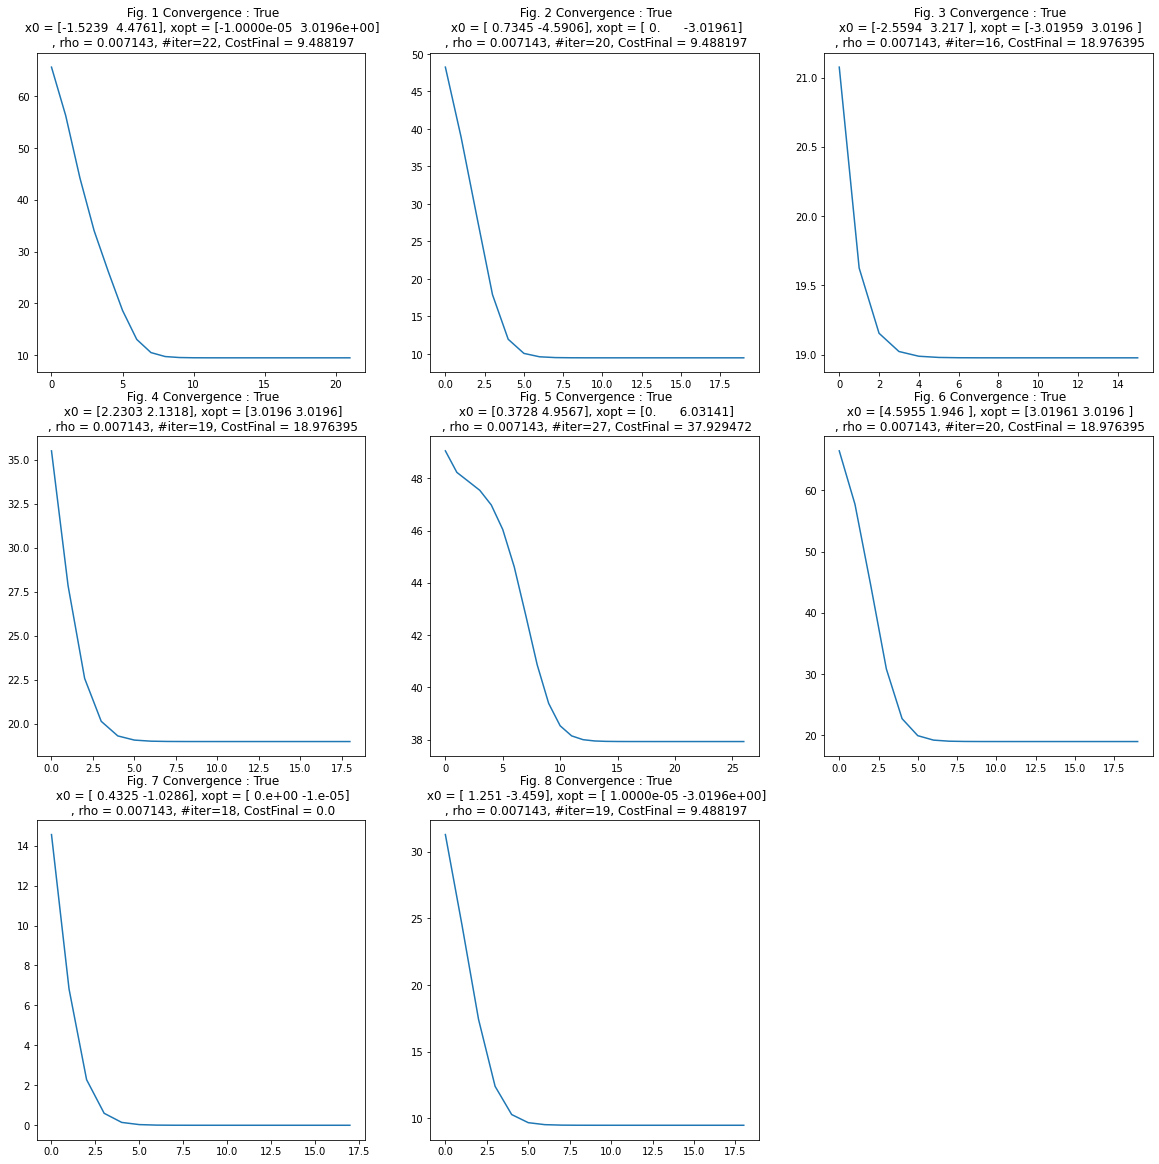

In [362]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy.random as rn
nbinitPoint = 1000
Bmin=[-math.pi*2,-math.pi*2] # minimal bound
Bmax=[math.pi*2,math.pi*2]  # maximal bound
x =np.zeros(nbinitPoint)
y =np.zeros(nbinitPoint)
rhoT =np.zeros(nbinitPoint)
convergenceT = np.zeros(nbinitPoint)
nbiterT = np.zeros(nbinitPoint)
JOptT= np.zeros(nbinitPoint)
timeT=np.zeros(nbinitPoint)
xOptT=np.zeros((nbinitPoint,2))
x0T=np.zeros((nbinitPoint,2))
rho0 = 0.01 # initialisation of the step value
nbitermax = 140000 # fixe number of iteration
tolerance = 1e-08 # tolerance value for stop criterion on changing value of cost function
plt.figure(figsize=(20,20))
for i in range(nbinitPoint):
    nbCallJcost = 0
    nbCallGrad = 0
    x0[0] = rn.random_sample()*10-5
    x0[1] = rn.random_sample()*10-5
    x[i]=x0[0]
    y[i]=x0[1]
    start = time.time()
    rho,convergence,nbiter,JOpt,xOpt,result = searchRho(x0,rho0,Bmin,Bmax,nbitermax,tolerance)
    end = time.time()
    rhoT[i]=rho
    convergenceT[i]=convergence
    nbiterT[i]=nbiter
    timeT[i]=end-start
    JOptT[i]=JOpt
    xOptT[i]=xOpt
    x0T[i]=x0
    if (i % (nbinitPoint//8)) == 0:
        see_EggResult(x0,xOpt,JOpt, result,i // (nbinitPoint//8),convergence,rho,nbiter)

### 9 sample convergence graph for 9 different starting point

I have plotted above 9 random graph with objective value on y-axis and iteration number on x-axis

**We can see in this random sample that the algorithm converges several times to local optimum and only 1 time to the global optimal (fig 3)**

### Result of the 1000 sample starting points test convergence

We can see that the convergence works for the whole 1000 starting points and that for some starting point the global minimum was found (objectiv value : minimum = 0.0)

In [363]:
print("Convergence : {0} convergences over {1}".format(sum(convergenceT),nbinitPoint))
print("\nRho : \t\t minimum {0}, \t maximum {1}, \t mean {2}".format(np.round(min(rhoT),6),np.around(np.max(rhoT),6),np.around(np.mean(rhoT),6)))
print("Iter. number : \t minimum {0}, \t\t maximum {1}, \t\t mean {2}".format(min(nbiterT),np.max(nbiterT),np.mean(nbiterT)))
print("Obj. value :\t minimum {0}, \t\t maximum {1},\t mean {2}".format(np.around(min(JOptT),6),np.around(np.max(JOptT),6),np.around(np.mean(JOptT),6)))     
print("Exec. time. : \t minimum {0}ms,\t\t maximum {1}ms, \t mean {2}ms".format(round(min(timeT)*1000,1), \
                                                                round(np.max(timeT)*1000,3),round(np.mean(timeT)*1000,1)))
      

Convergence : 1000.0 convergences over 1000

Rho : 		 minimum 0.007143, 	 maximum 0.007143, 	 mean 0.007143
Iter. number : 	 minimum 12.0, 		 maximum 45.0, 		 mean 19.544
Obj. value :	 minimum 0.0, 		 maximum 75.858944,	 mean 14.202899
Exec. time. : 	 minimum 0.0ms,		 maximum 2.994ms, 	 mean 0.2ms


With EggCrate function, the "fix step gradient" method is simple (always the same rho used for all the points) and quick (iteration between 10 and 34), BUT the global optimum is only reached when the statring point is closed to the optimal point

**The following graph shows the various optimal points reached by the algorithm and the region that converges to the global optimum**

In [341]:
globalOpt = [ (x < 0.01) for x in JOptT]
xGlobX = [i[0] for indx,i in enumerate(x0T) if globalOpt[indx] == True]
xGlobY = [i[1] for indx,i in enumerate(x0T) if globalOpt[indx] == True]

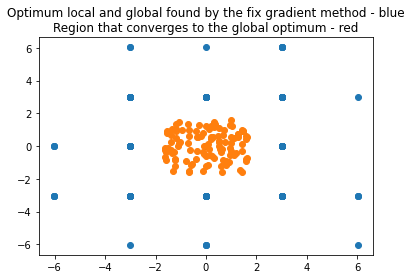

In [342]:
plt.scatter(xOptT[:,0],xOptT[:,1])
plt.scatter(xGlobX,xGlobY)
plt.title("Optimum local and global found by the fix gradient method - blue\nRegion that converges to the global optimum - red")
plt.show()

### It's finally interesting to see the % of starting points thats converges to optimal minimum

In [343]:
print("% of starting point leading to global minium : {0} % ".format(100* sum([ (x < 0.01) for x in JOptT])/len(JOptT)))

% of starting point leading to global minium : 11.2 % 


# Ex2. Golinski's Speed Reducer - Gradient method

Here the function to minimize is 0.7854 * x[0] * x[1]^2 * (3.3333 * x[2]^2 + 14.9334 * x[2]-43.0934) 
         - 1.5079 * x[0] * (x[5]^2 + x[6]^2 ) + 7.477 * (x[5]^3 + x[6]^3 ) 
         + 0.7854 * (x[3] * x[5]^2 + x[4] * x[6]^2)

This is a complex function with 7 variables and also 11 constraint functions given in the documentation.

My idea is to try to use the Uzawa's algorithm because this algorithm combine gradient methode and ability to deals with constraints.

### Process I follow

Understanding the complexity of the function and of the constraints, it is highly probable that this function has lots of minimum. 

The first think was to calculate the different function needed : Gradient of the cost function and Gradient of the Lagrangien for x and for lambda

Not easy calculation !

I choose to take in account the restricted universe using a "clap" function that realize a projection on the search universe when the design variables goes out of this search universe.
The same for the lambda vector when it becomes negative

In [365]:
def J(x):
    return 0.7854*x[0]*x[1]**2*(3.3333*x[2]**2+14.9334*x[2]-43.0934) \
      - 1.5079*x[0]*(x[5]**2+x[6]**2)+7.477*(x[5]**3+x[6]**3) \
         + 0.7854*(x[3]*x[5]**2+x[4]*x[6]**2)

def grad(x):
    return np.array([ \
       0.7854*x[1]**2*(3.3333*x[2]**2+14.9334*x[2]-43.0934) - 1.5079*(x[5]**2+x[6]**2), \
       + 2*0.7854*x[0]*x[1]*(3.3333*x[2]**2+14.9334*x[2]-43.0934), \
       + 0.7854*x[0]*x[1]**2*(2*3.3333*x[2]+14.9334), \
       + 0.7854*(x[5]**2), \
        + 0.7854*(x[6]**2), \
		- 1.5079*2*x[0]*x[5]+7.477*3*(x[5]**2) + 2*0.7854*x[3]*x[5], \
       - 1.5079*2*x[0]*x[6]+7.477*3*(x[6]**2) + 2*0.7854*x[4]*x[6] ])      

def gradLagx(x,l):
    return grad(x) + np.array([
 27*l[0]*(-x[0]**(-2)*x[1]**(-2)*x[2]**(-1)) + 397.5*l[1]*(-x[0]**(-2)*x[1]**(-2)*x[2]**(-2)) + 5*l[7]*(-x[0]**(-2)*x[1]) +l[8]*(x[1]**(-1))/12 , \
 
 27*l[0]*(-2*x[0]**(-1)*x[1]**(-3)*x[2]**(-1)) + 397.5*l[1]*(-2*x[0]**(-1)*x[1]**(-3)*x[2]**(-2)) + 1.93*l[2]*(-x[1]**(-2)*x[2]**(-1)*x[3]**(3)*x[5]**(-4)) \
	+ 1.93*l[3]*(-x[1]**(-2)*x[2]**(-1)*x[4]**(3)*x[6]**(-4)) + l[4]/110.0*(x[5]**(-3)*((745**2*x[3]**2*x[1]**(-2)*x[2]**(-2))**(-0.5)) * (-2*745**2*x[3]**2*x[1]**(-3)*x[2]**(-2))) \
    + l[5]/85.0*(x[6]**(-3)*((745**2*x[4]**2*x[1]**(-2)*x[2]**(-2))**(-0.5))* (-2*745**2*x[4]**2*x[1]**(-3)*x[2]**(-2))) + l[6]*(x[2])/40 + 5*l[7]*(x[0]**(-1)) \
	+ +l[8]*(-x[0]*x[1]**(-2))/12 , \
	
 27*l[0]*(-x[0]**(-1)*x[1]**(-2)*x[2]**(-2)) + 397.5*l[1]*(-2*x[0]**(-1)*x[1]**(-2)*x[2]**(-3))  + 1.93*l[2]*(-x[1]**(-1)*x[2]**(-2)*x[3]**(3)*x[5]**(-4)) \
	+ 1.93*l[3]*(-x[1]**(-1)*x[2]**(-2)*x[4]**(3)*x[6]**(-4)) + l[4]/110.0*(x[5]**(-3)*((745**2*x[3]**2*x[1]**(-2)*x[2]**(-2))**(-0.5))* (-2*745**2*x[3]**2*x[1]**(-2)*x[2]**(-3))) \
	+ l[5]/85.0*(x[6]**(-3)*((745**2*x[4]**2*x[1]**(-2)*x[2]**(-2))**(-0.5))* (-2*745**2*x[4]**2*x[1]**(-2)*x[2]**(-3))) + l[6]*(x[1])/40, \
	
 1.93*l[2]*(3*x[1]**(-1)*x[2]**(-1)*x[3]**(2)*x[5]**(-4)) + l[4]/110.0*x[5]**(-3)*((745**2*x[3]**2*x[1]**(-2)*x[2]**(-2)+16.9*1000000)**(-0.5))* (745**2*2*x[3]*x[1]**(-2)*x[2]**(-2)) \
    + l[9]*(-(1.5*x[5]+1.9)*x[3]**(-2)), \
	
 1.93*l[3]*(3*x[1]**(-1)*x[2]**(-1)*x[4]**(2)*x[6]**(-4)) + l[5]/85.0*(x[6]**(-3)*((745**2*x[3]**2*x[1]**(-2)*x[2]**(-2)+16.9*1000000)**(-0.5))* (745**2*2*x[4]*x[1]**(-2)*x[2]**(-2))) \
    +l[10]*(-(1.1*x[6]+1.9)*x[4]**(-2)) , \
	
 1.93*l[2]*(-4*x[1]**(-1)*x[2]**(-1)*x[3]**(3)*x[5]**(-5)) + l[4]/110.0* (- 3 * (745**2*x[3]**2*x[1]**(-2)*x[2]**(-2)+16.9*1000000)**(0.5)*x[5]**(-4)) \
	+ l[9]*(1.5*x[3]**(-1)), \
	
 1.93*l[3]*(-4*x[1]**(-1)*x[2]**(-1)*x[4]**(3)*x[6]**(-5)) + l[5]/85.0* ( - 3 * (745**2*x[4]**2*x[1]**(-2)*x[2]**(-2)+157.5*1000000)**(0.5)*x[6]**(-4)) \
    +l[10]*(1.1*x[4]**(-1)) ])

def gradLagl(x):
    return np.array([ \
27*x[0]**(-1)*x[1]**(-2)*x[2]**(-1) - 1, \
+ 397.5*x[0]**(-1)*x[1]**(-2)*x[2]**(-2) -1, \
+ 1.93* x[1]**(-1)*x[2]**(-1)*x[3]**(3)*x[5]**(-4) - 1, \
+ 1.93* x[1]**(-1)*x[2]**(-1)*x[4]**(3)*x[6]**(-4) - 1, \
+ 1.0/110.0*(745**2*x[3]**(2)*x[1]**(-2)*x[2]**(-2)+16.9*1000000)**(0.5)*x[5]**(-3) - 1, \
+ 1.0/85.0*(745**2*x[4]**(2)*x[1]**(-2)*x[2]**(-2)+157.5*1000000)**(0.5)*x[6]**(-3) - 1, \
+ x[1]*x[2]/40 - 1, \
+ 5*x[1]*x[0]**(-1) - 1, \
+ x[0]*x[1]**(-1)/12 - 1, \
+ (1.5*x[5]+1.9)*x[3]**(-1) - 1, \
+ (1.1*x[6]+1.9)*x[4]**(-1) -1 ])

def checkl(l):
    for i in range(len(l)):
        if l[i] < 0 : l[i] = 0.0
    

def clap(x,xmin,xmax):
    for i in range(len(x)):
        if x[i] < xmin[i] : x[i]=xmin[i]
        elif x[i] > xmax[i] : x[i]=xmax[i]

def constraintViolation(l):
    count = 0
    for i in range(len(l)):
        if l[i] > 0 : count = count +1
    return count

def gradientFixStepConstraint(x0,rho1,rho2,nbiter,xmin,xmax):
    l = np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])
    x = x0
    Jlist = []
    CVlist = []
    xlist = []
    for n in range(nbiter):
        xlist.append(x)
        Jlist.append(J(x))
        CVlist.append(constraintViolation(gradLagl(x)))
        x = x - rho1 * gradLagx(x,l)
        clap(x,xmin,xmax)
        l = l + rho2 * gradLagl(x)
        checkl(l)
    return Jlist, CVlist , x , l ,xlist

I first test my calculation for gradient and Lagrangien with numeric calculation to be sure that there were no calculation errors.

For instance the test of gradient below, compare the derivative I calculate to a numeric calculation : And it is quit good :

In [366]:
x0=np.array([2.87,0.73,18.73,7.86,7.76,3.04,5.18,])
dt = 0.0000001
numericGradient = np.zeros(7)
for i in range(7):
    delta = np.zeros(7)
    delta[i] = dt
    numericGradient[i] = (J(x0+delta)-J(x0))/dt
print("gradient function {0}".format(grad(x0)))
print("numeric controle {0}".format(numericGradient))

gradient function [ 534.05982065 4627.03605771  167.92757379    7.25835264   21.07416696
  218.51940128  620.18400556]
numeric controle [ 534.05981816 4627.03636913  167.92757833    7.2583498    21.07416549
  218.51940346  620.18401877]


I try different rho1 and rho2 parameters for the alogorythm. Rho1 is for the solution gradient and rho2 is for the lambda optimization.
A good compromise is rho1 = 0.0001 and lambda = 10.

I run below the algorithm, with a number of iteration of 50000 and a random starting point

 minimum cost : 2994.3550261330092,
 optimal position : [ 3.5         0.7        17.          7.3         7.71531991  3.35021467
  5.28665446] 
 values of the constraint : [-7.39152804e-02 -1.97998527e-01 -4.99172248e-01 -9.04643905e-01
 -1.40998324e-14 -6.91668944e-14 -7.02500000e-01 -5.63660230e-13
 -5.83333333e-01 -5.13257535e-02 -1.12786447e-10]

 execution time : 9.637961387634277 s
We can check that all the values of the constraint vector are negative


2941

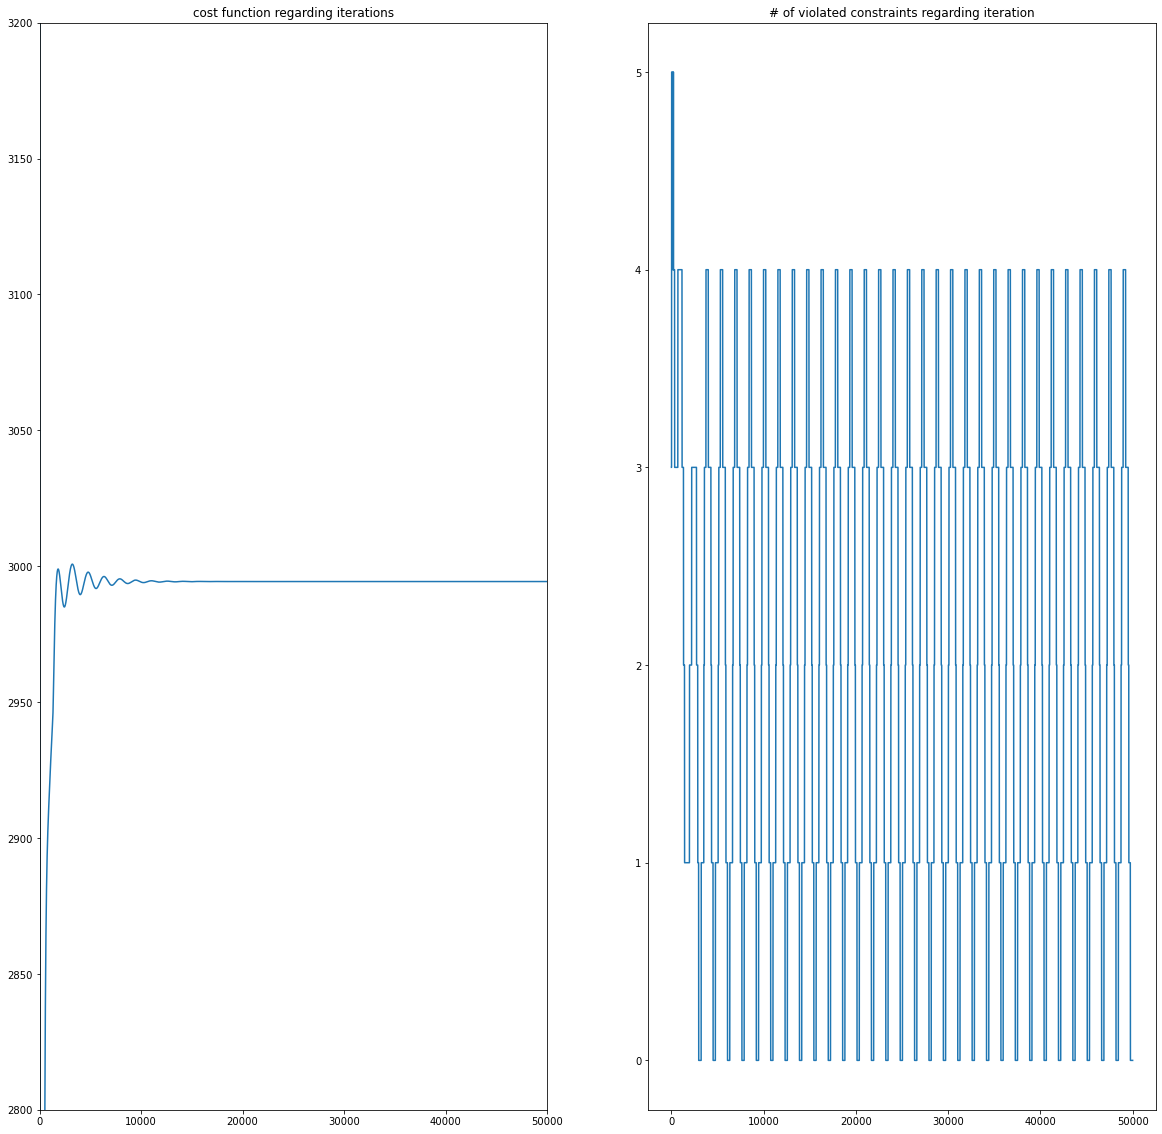

In [369]:
import time

xmin=(2.6,0.7,17.0,7.3,7.3,2.9,5.0)
xmax=(3.6,0.8,28.0,8.3,8.3,3.9,5.9)
l = np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])
x0 = np.zeros(7)
for i in range(7):
    x0[i]=rn.uniform(xmin[i],xmax[i])
    
clap(x0,xmin,xmax)

start = time.time()
Jlist, CVlist, lastx, l ,xlist = gradientFixStepConstraint(x0,0.0001,10,50000,xmin,xmax)
end= time.time()
a=[i for i, e in enumerate(CVlist) if e == 0]
b=min([(Jlist[x],x)  for x in a])

print(" minimum cost : {0},\n optimal position : {1} \n values of the constraint : {2}".format(b[0],xlist[b[1]],gradLagl(xlist[b[1]])))
print("\n execution time : {0} s".format(end - start))
print("We can check that all the values of the constraint vector are negative")
plt.figure(figsize = (20,20))

plt.subplot(121)
plt.title("cost function regarding iterations")
plt.axis([0,50000,2800,3200])
plt.plot(Jlist)
plt.subplot(122)
plt.title("# of violated constraints regarding iteration")
plt.plot(CVlist)
CVlist.index(0)

The graph shows that :

* the cost converges to a very low value : 2994.355026133452
* but the number of constraint violation oscillate between 0 and 4 which means that the minimization is quit instable in terme of constraint violation.

I need to have a rho2 quit high (10) other wise the algorithm do not take in account the constraints and converges with a very low cost function but with a very high number of constraints. But I think that the instability of the solution (regarding constraint violation) is a consequence of this high rho2.

A possible improvment of the algorythm could be to decrease rho2 after a certain time. 

It's interesting to have a look at the values of the objectiv function for which the constraints are satisfied

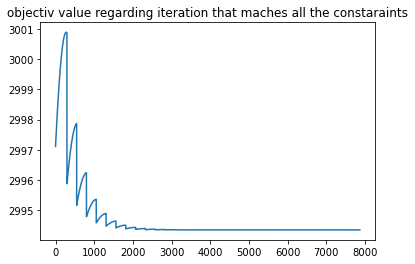

In [254]:
plt.title("objectiv value regarding iteration that maches all the constaraints")
plt.plot([i for indx,i in enumerate(Jlist) if CVlist[indx] == 0])
plt.show()

# Ex 3. Banana function - Heuristic technics

I've decided to use the same PSO algorithm that I use and slightly modify in the first exercice

The PSO algorithm is adapted to continuous variable, quick and start from several starting point instead of just one in gradient method. So I think that it should be adapted to the "Banana function"


In [8]:
#from pyswarm import pso

def Jb(x): 
    return 100*(x[1]-x[0]**2)**2+(1-x[0])**2

def plotPSO(nbTry,costT,convergeT,timeT,xoptT):
    plt.figure(figsize=(15,5))
    plt.subplot(141)
    plt.axis([0, nbTry, 0, 1])
    plt.title("cost")
    plt.plot(range(nbTry),costT, 'b')
    plt.subplot(142)
    plt.title("Convergence")
    plt.plot(range(nbTry),convergeT, 'b')
    plt.subplot(143)
    plt.title("Time")
    plt.plot(range(nbTry),timeT, 'b')
    plt.subplot(144)
    plt.title("Distance to optimum")
    plt.axis([0, nbTry, 0, 1])
    plt.plot(range(nbTry),xoptT, 'b')
    print("distance to optimal point <0.1 : {0} / {1},  mean time exec : {2} ms " \
          .format(sum([(x < 0.1) for x  in xoptT]),nbTry ,\
            np.array(timeT).mean()*1000))

After a few tests, it's not a surpise to see that the algo found the minimum "quite easily" but it's interesting to see now the impact of the different parameters of the algorithm and the way to tune these parameters in order to find an optimized execution.

These are the parameters that can be given to the algorithm

* swarmsize : The number of particles in the swarm (Default: 100)
* omega : Particle velocity scaling factor (Default: 0.5)
* phip : Scaling factor to search away from the particle’s best known position (Default: 0.5)
* phig : Scaling factor to search away from the swarm’s best known position (Default: 0.5)
* maxiter : The maximum number of iterations for the swarm to search (Default: 100)
* minstep : The minimum stepsize of swarm’s best position before the search terminates (Default: 1e-8)
* minfunc : The minimum change of swarm’s best objective value before the search terminates (Default: 1e-8)

The idea is to first try the algorithm with the default values, and then to try to adjust the parameters to see if better results can be achieved. For this, the algorithm is run 100 times to have an average vision of the result and the four following graphes are plotted :

* cost function for the 100 runs
* convergence status for the 100 runs
* time to find convergence for the 100 runs
* distance to the optimal point(1,1) for the 100 runs

This first try give 100% of convergence to minimum and an execution time around 46ms

distance to optimal point <0.1 : 100 / 100,  mean time exec : 46.92033767700195 ms 


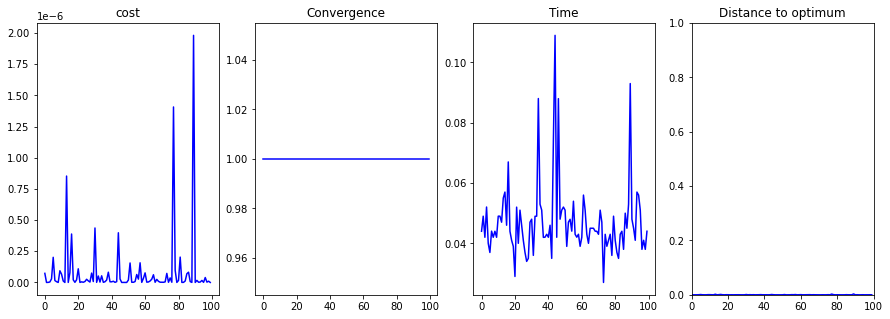

In [370]:
import time


lb = [-5.0]*2
ub = [5.0]*2
nbTry=100
costT = []
convergeT = []
nbIterT = []
timeT = []
xoptT=[]
converge = False
for i in range(nbTry):
    start= time.time()
    xopt, fopt,converge, nbiter,objT = pso(Jb,lb,ub,debug=False)
    end = time.time()
    timeT.append(end-start)
    costT.append(fopt)
    convergeT.append(converge)
    nbIterT.append(nbiter)
    xoptT.append(((xopt[0]-1)**2+(xopt[1]-1)**2)**(0.5))
plotPSO(nbTry,costT,convergeT,timeT,xoptT)

**Decreasing swarmsize by step of 10 shows that 70 is a good compromise**

* % of distance to optimal point is > 98% smaller then 0.1
* the execution time decrease down to around 38ms

distance to optimal point <0.1 : 99 / 100,  mean time exec : 38.68971347808838 ms 


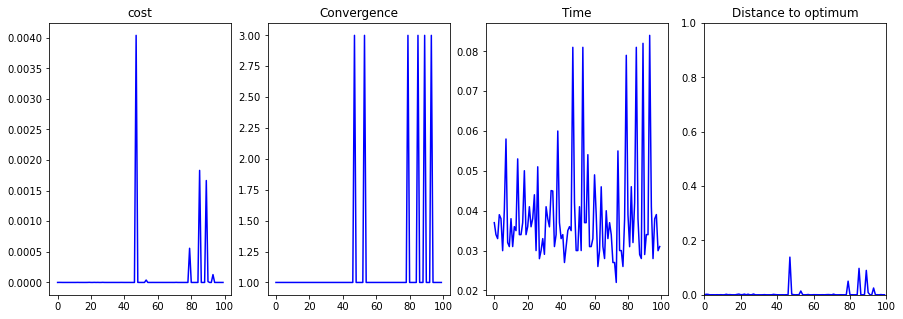

In [373]:
import time


lb = [-5.0]*2
ub = [5.0]*2
nbTry=100
costT = []
convergeT = []
nbIterT = []
timeT = []
xoptT=[]
converge = False
for i in range(nbTry):
    start= time.time()
    xopt, fopt,converge, nbiter,objT = pso(Jb,lb,ub,debug=False,swarmsize=70)
    end = time.time()
    timeT.append(end-start)
    costT.append(fopt)
    convergeT.append(converge)
    nbIterT.append(nbiter)
    xoptT.append(((xopt[0]-1)**2+(xopt[1]-1)**2)**(0.5))
plotPSO(nbTry,costT,convergeT,timeT,xoptT)


**Another idea is to change the "swam parameters"**

* omega : Particle velocity scaling factor (Default: 0.5)
* phip : Scaling factor to search away from the particle’s best known position (Default: 0.5)
* phig : Scaling factor to search away from the swarm’s best known position (Default: 0.5)

My searches on those 3 parameters shows that a good compromise is : omega=0.3, phip=0.99 and phig=0.5

The quality of the found optimal is still good and the execution time goes down around 30ms

distance to optimal point <0.1 : 100 / 100,  mean time exec : 29.38997983932495 ms 


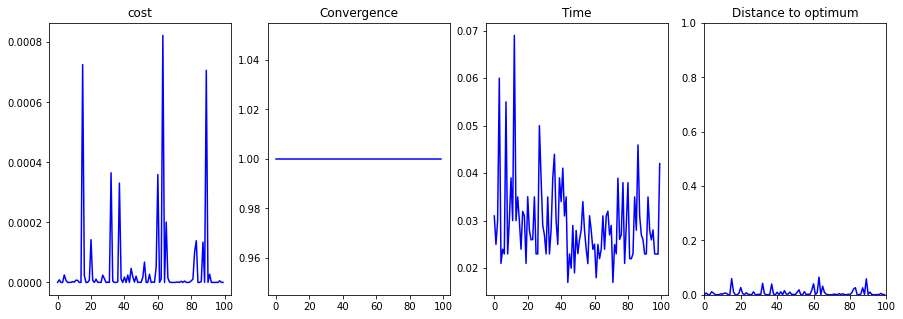

In [384]:
lb = [-5.0]*2
ub = [5.0]*2
nbTry=100
costT = []
convergeT = []
nbIterT = []
timeT = []
xoptT=[]
converge = False
for i in range(nbTry):
    start= time.time()
    xopt, fopt,converge, nbiter,objT = pso(Jb,lb,ub,debug=False,swarmsize = 70, \
                          phig=0.5, phip= 1.5, omega=0.3)
    end = time.time()
    timeT.append(end-start)
    costT.append(fopt)
    convergeT.append(converge)
    nbIterT.append(nbiter)
    xoptT.append(((xopt[0]-1)**2+(xopt[1]-1)**2)**(0.5))
plotPSO(nbTry,costT,convergeT,timeT,xoptT)

9 plotting with cost function regarding iteration runned with the final parameters.

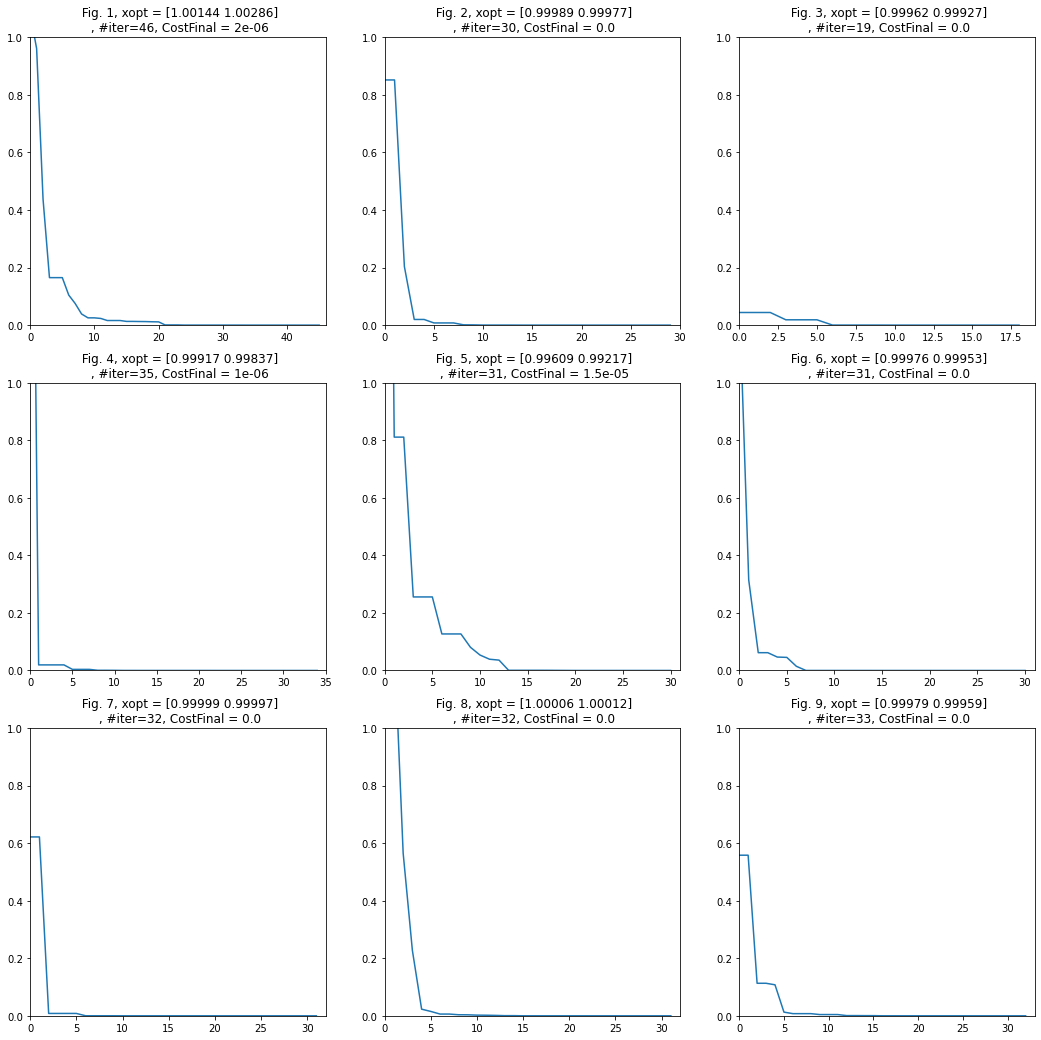

In [385]:
def see_ex3Result(xOpt,JOpt, result,i,nbiter):
    title =  " Fig. " + str(i+1) + ", xopt = " \
    + str(np.around(xOpt,5)) +"\n "+ ", #iter="+ str(nbiter) \
    +", CostFinal = " + str(np.around(JOpt,6))
    plt.subplot(3,3,i+1)
    plt.axis([0,len(result),0,1])
    plt.title(title)
    plt.plot(result)


lb = [-5.0]*2
ub = [5.0]*2
nbTry=100
costT = []
convergeT = []
nbIterT = []
timeT = []
xoptT=[]
converge = False
plt.figure(figsize=(18,18))
for i in range(nbTry):
    objT=[]
    start= time.time()
    xopt, fopt,converge, nbiter,objT = pso(Jb,lb,ub,debug=False,swarmsize = 70,maxiter=100,minstep=1e-08,minfunc=1e-08, \
                          phig=0.5, phip= 0.99, omega=0.3)
    end = time.time()
    timeT.append(end-start)
    costT.append(fopt)
    convergeT.append(converge)
    nbIterT.append(nbiter)
    xoptT.append(((xopt[0]-1)**2+(xopt[1]-1)**2)**(0.5))
    if (i % (nbTry//8)) == 0:
        see_ex3Result(xopt,fopt, objT,i // (nbTry//8),nbiter)

# Ex 3.  Eggcrate function - Heuristic technics

I've decided to use the same PSO algorithm used in the previous exercices

The PSO algorithm is adapted to continuous variable, quick and start from several starting point instead of just one in gradient method. So I think that it should be adapted to the "Eggcrate function" and able to find global optimum rather than local optimum


After a few tests, it's not a surpise to see that the PSO found the global minimum "quite easily" but it's interesting to see now the impact of the different parameters of the algorythm and the way to tune this parameter in order to find an optimized execution.

These are the parameters that can be given to the algorithm

* swarmsize : The number of particles in the swarm (Default: 100)
* omega : Particle velocity scaling factor (Default: 0.5)
* phip : Scaling factor to search away from the particle’s best known position (Default: 0.5)
* phig : Scaling factor to search away from the swarm’s best known position (Default: 0.5)
* maxiter : The maximum number of iterations for the swarm to search (Default: 100)
* minstep : The minimum stepsize of swarm’s best position before the search terminates (Default: 1e-8)
* minfunc : The minimum change of swarm’s best objective value before the search terminates (Default: 1e-8)

The idea is to first try the algorithm with the default values, and then to try to adjust the parameters to see if better results can be achieved. For this, the algorithm is run 100 times to have an average vision of the result and the four following graphes are plotted :

* cost function for the 100 runs
* convergence status for the 100 runs
* time to find convergence for the 100 runs
* distance to the optimal point(1,1) for the 100 runs

This first try give 100% of convergence to minimum and an execution time around 35ms

In [386]:
def J(x):
    return x[0]**2+x[1]**2+25*((math.sin(x[0]))**2+(math.sin(x[1]))**2)


distance to optimal point <0.1 : 100 / 100,  mean time exec : 35.10459899902344 ms 


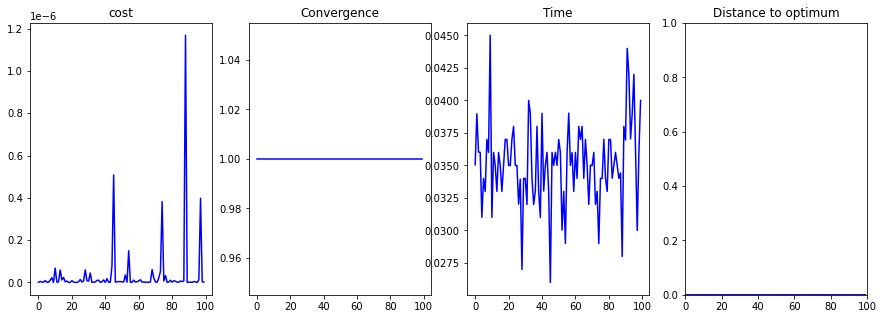

In [387]:
import time

lb = [-2*math.pi]*2
ub = [2*math.pi]*2
nbTry=100
costT = []
convergeT = []
nbIterT = []
timeT = []
xoptT=[]
converge = False
for i in range(nbTry):
    start= time.time()
    xopt, fopt,converge, nbiter,objT = pso(J,lb,ub,debug=False)
    end = time.time()
    timeT.append(end-start)
    costT.append(fopt)
    convergeT.append(converge)
    nbIterT.append(nbiter)
    xoptT.append(((xopt[0])**2+(xopt[1])**2)**(0.5))
plotPSO(nbTry,costT,convergeT,timeT,xoptT)


**I decrease the swarmsize in a loop function and print the result of each 100 runs to find the best swarmsize**

In [389]:
import time

lb = [-2*math.pi]*2
ub = [2*math.pi]*2
nbTry=100
swarmsize=100
for j in range(25):
    costT = []
    convergeT = []
    nbIterT = []
    timeT = []
    xoptT=[]
    converge = False
    for i in range(nbTry):
        start= time.time()
        xopt, fopt,converge, nbiter,objT = pso(J,lb,ub,debug=False,swarmsize = swarmsize)
        end = time.time()
        timeT.append(end-start)
        costT.append(fopt)
        convergeT.append(converge)
        nbIterT.append(nbiter)
        xoptT.append(((xopt[0])**2+(xopt[1])**2)**(0.5))
    print("# swarm : {3}, % convergence : {0} / {1},  max Cost : {2}, time = {4}  " \
          .format(sum([(x < 0.1) for x  in xoptT]),nbTry , round(np.max(costT),2),swarmsize,np.round(np.mean(timeT)*1000),5)) 
    swarmsize = swarmsize - 4


# swarm : 100, % convergence : 100 / 100,  max Cost : 0.0, time = 34.0  
# swarm : 96, % convergence : 100 / 100,  max Cost : 0.0, time = 33.0  
# swarm : 92, % convergence : 100 / 100,  max Cost : 0.0, time = 36.0  
# swarm : 88, % convergence : 100 / 100,  max Cost : 0.0, time = 34.0  
# swarm : 84, % convergence : 100 / 100,  max Cost : 0.0, time = 32.0  
# swarm : 80, % convergence : 100 / 100,  max Cost : 0.0, time = 31.0  
# swarm : 76, % convergence : 100 / 100,  max Cost : 0.0, time = 28.0  
# swarm : 72, % convergence : 100 / 100,  max Cost : 0.0, time = 27.0  
# swarm : 68, % convergence : 100 / 100,  max Cost : 0.0, time = 26.0  
# swarm : 64, % convergence : 100 / 100,  max Cost : 0.0, time = 25.0  
# swarm : 60, % convergence : 100 / 100,  max Cost : 0.0, time = 23.0  
# swarm : 56, % convergence : 100 / 100,  max Cost : 0.0, time = 22.0  
# swarm : 52, % convergence : 100 / 100,  max Cost : 0.0, time = 20.0  
# swarm : 48, % convergence : 98 / 100,  max Cost : 9.49, time 

**30 seems to be a good compromise for this swarmsize**

In that case the execution time is around 15ms

**At that time it is interesting to have a look at the graph of the cost function related to the number of iteration**

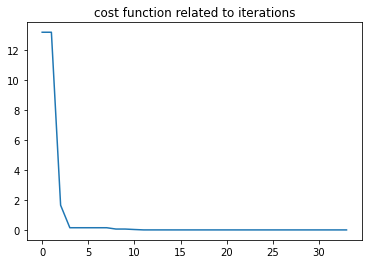

In [392]:
xopt, fopt,converge, nbiter,objT = pso(J,lb,ub,debug=False,swarmsize = 30)
plt.title("cost function related to iterations")
plt.plot(objT)
plt.show()


We can see that the cost function is decreasing very rapidly, so we can imagine to be able to improve the execution time by modifyin the criteria of the stop function on the objective function

**So I decrease the minfunc parameter in a loop function and print the result of each 100 runs to find the best minfunc**

In [393]:
import time

lb = [-2*math.pi]*2
ub = [2*math.pi]*2
nbTry=100
swarmsize=30
minfunc=1e-08
for j in range(8):
    costT = []
    convergeT = []
    nbIterT = []
    timeT = []
    xoptT=[]
    converge = False
    for i in range(nbTry):
        start= time.time()
        xopt, fopt,converge, nbiter,objT = pso(J,lb,ub,debug=False,swarmsize = swarmsize,minfunc=minfunc)
        end = time.time()
        timeT.append(end-start)
        costT.append(fopt)
        convergeT.append(converge)
        nbIterT.append(nbiter)
        xoptT.append(((xopt[0])**2+(xopt[1])**2)**(0.5))
    print("# minfunc : {3}, % convergence : {0} / {1},  max Cost: {2}, time = {4}  " \
          .format(sum([(x < 0.1) for x  in xoptT]),nbTry , round(np.max(costT),2),round(minfunc,9),np.round(np.mean(timeT)*1000),5)) 
    minfunc = minfunc * 10


# minfunc : 1e-08, % convergence : 99 / 100,  max Cost: 9.49, time = 13.0  
# minfunc : 1e-07, % convergence : 97 / 100,  max Cost: 9.49, time = 11.0  
# minfunc : 1e-06, % convergence : 99 / 100,  max Cost: 9.49, time = 10.0  
# minfunc : 1e-05, % convergence : 96 / 100,  max Cost: 9.49, time = 9.0  
# minfunc : 0.0001, % convergence : 98 / 100,  max Cost: 9.49, time = 8.0  
# minfunc : 0.001, % convergence : 98 / 100,  max Cost: 9.49, time = 7.0  
# minfunc : 0.01, % convergence : 98 / 100,  max Cost: 0.31, time = 6.0  
# minfunc : 0.1, % convergence : 83 / 100,  max Cost: 14.71, time = 4.0  


**Results are good until minifunc = 1e-4**

The execution time become close to 8 ms

**with those parameters fixed, I plot 9 graph, choosed randomly, showing cost function related to number of iteration**

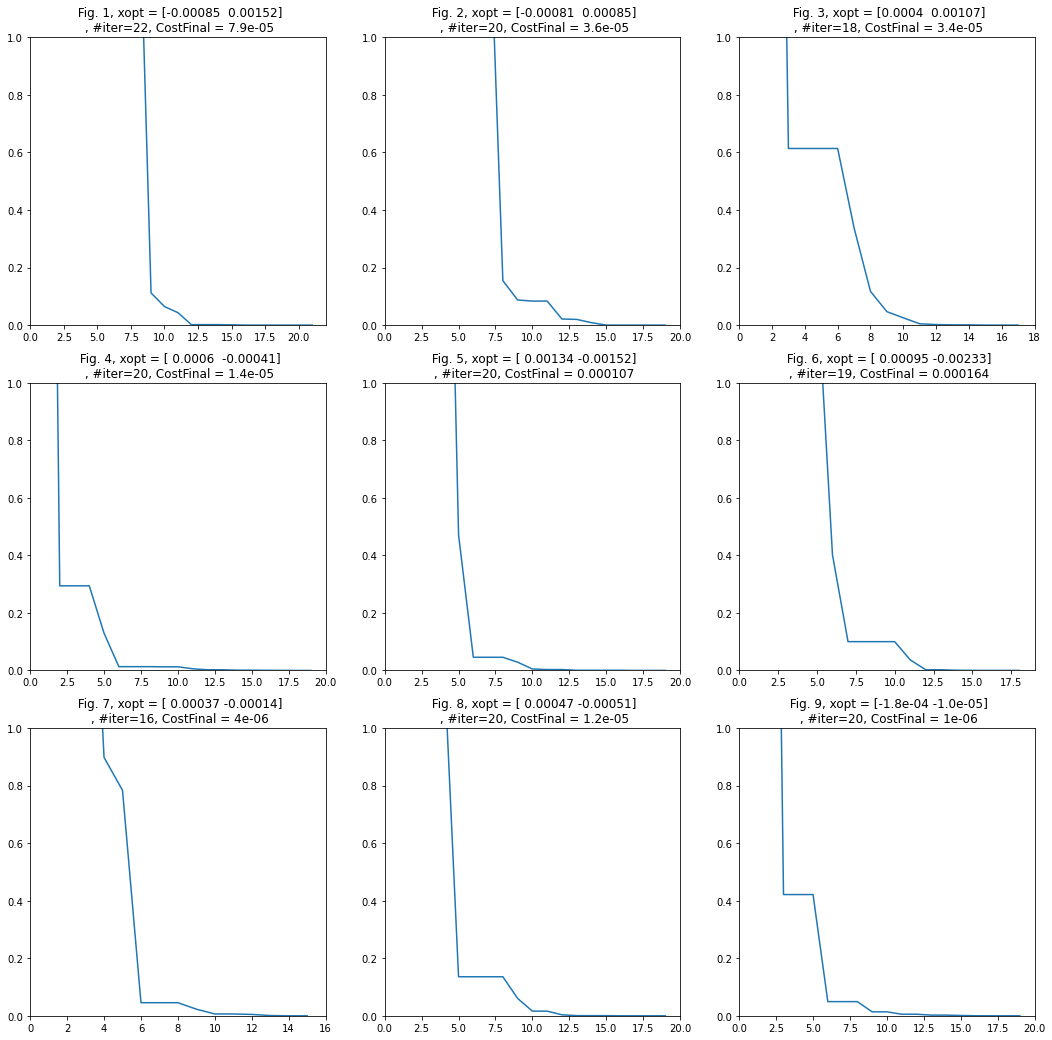

In [394]:
lb = [-2*math.pi]*2
ub = [2*math.pi]*2
nbTry=100
costT = []
convergeT = []
nbIterT = []
timeT = []
xoptT=[]
converge = False
plt.figure(figsize=(18,18))
for i in range(nbTry):
    objT=[]
    start= time.time()
    xopt, fopt,converge, nbiter,objT = pso(J,lb,ub,debug=False,swarmsize = 30,minfunc=1e-04 )
    end = time.time()
    timeT.append(end-start)
    costT.append(fopt)
    convergeT.append(converge)
    nbIterT.append(nbiter)
    xoptT.append(((xopt[0]-1)**2+(xopt[1]-1)**2)**(0.5))
#plotPSO(nbTry,costT,convergeT,timeT,xoptT)
    if (i % (nbTry//8)) == 0:
        #print(i // (nbTry//7))
        see_ex3Result(xopt,fopt, objT,i // (nbTry//8),nbiter)

# EX 3. Golinski's with PSO - Heuristic Technics

The idea is to run the PSO algorithm on Golinski speed reducer.

The implementation of this algorithm enable to define a constraint function and also boundaries for the variables. So it seems quit wall adapted to our case.


In [398]:
#from pyswarm import pso

def JGh(x):
    return 0.7854*x[0]*x[1]**2*(3.3333*x[2]**2+14.9334*x[2]-43.0934) \
         - 1.5079*x[0]*(x[5]**2+x[6]**2)+7.477*(x[5]**3+x[6]**3) \
         + 0.7854*(x[3]*x[5]**2+x[4]*x[6]**2)


def const(x):
    return np.array([ \
-27*x[0]**(-1)*x[1]**(-2)*x[2]**(-1) + 1, \
- 397.5*x[0]**(-1)*x[1]**(-2)*x[2]**(-2) +1, \
- 1.93* x[1]**(-1)*x[2]**(-1)*x[3]**(3)*x[5]**(-4) + 1, \
- 1.93* x[1]**(-1)*x[2]**(-1)*x[4]**(3)*x[6]**(-4) + 1, \
- 1.0/110.0*(745**2*x[3]**(2)*x[1]**(-2)*x[2]**(-2)+16.9*1000000)**(0.5)*x[5]**(-3) + 1, \
- 1.0/85.0*(745**2*x[4]**(2)*x[1]**(-2)*x[2]**(-2)+157.5*1000000)**(0.5)*x[6]**(-3) + 1, \
- x[1]*x[2]/40 + 1, \
- 5*x[1]*x[0]**(-1) + 1, \
- x[0]*x[1]**(-1)/12 + 1, \
- (1.5*x[5]+1.9)*x[3]**(-1) + 1, \
- (1.1*x[6]+1.9)*x[4]**(-1) +1 ])


xmin=[2.6,0.7,17,7.3,7.3,2.9,5.0]
xmax=[3.6,0.8,28,8.3,8.3,3.9,5.9]

In [399]:
#from pyswarm import pso

def JGh(x):
    return 0.7854*x[0]*x[1]**2*(3.3333*x[2]**2+14.9334*x[2]-43.0934) \
         - 1.5079*x[0]*(x[5]**2+x[6]**2)+7.477*(x[5]**3+x[6]**3) \
         + 0.7854*(x[3]*x[5]**2+x[4]*x[6]**2)


def const(x):
    return np.array([ \
-27*x[0]**(-1)*x[1]**(-2)*x[2]**(-1) + 1, \
- 397.5*x[0]**(-1)*x[1]**(-2)*x[2]**(-2) +1, \
- 1.93* x[1]**(-1)*x[2]**(-1)*x[3]**(3)*x[5]**(-4) + 1, \
- 1.93* x[1]**(-1)*x[2]**(-1)*x[4]**(3)*x[6]**(-4) + 1, \
- 1.0/110.0*(745**2*x[3]**(2)*x[1]**(-2)*x[2]**(-2)+16.9*1000000)**(0.5)*x[5]**(-3) + 1, \
- 1.0/85.0*(745**2*x[4]**(2)*x[1]**(-2)*x[2]**(-2)+157.5*1000000)**(0.5)*x[6]**(-3) + 1, \
- x[1]*x[2]/40 + 1, \
- 5*x[1]*x[0]**(-1) + 1, \
- x[0]*x[1]**(-1)/12 + 1, \
- (1.5*x[5]+1.9)*x[3]**(-1) + 1, \
- (1.1*x[6]+1.9)*x[4]**(-1) +1 ])



In [411]:
def plotPSO2(nbTry,costT,convergeT,timeT,xoptT):
    plt.figure(figsize=(15,5))
    plt.subplot(141)
    #plt.axis([0, nbTry, 0, 1])
    plt.title("cost")
    plt.plot(range(nbTry),costT, 'b')
    plt.subplot(142)
    plt.title("Convergence")
    plt.plot(range(nbTry),convergeT, 'b')
    plt.subplot(143)
    plt.title("Time")
    plt.plot(range(nbTry),timeT, 'b')
    print("minimum cost {0},  mean time exec : {1} ms " \
          .format(min(costT) ,\
            np.array(timeT).mean()*1000))

**As for the previous exemple the idea is to first test what happens with the standard parameters of PSO**

minimum cost 4073.4162369180576,  mean time exec : 452.04994678497314 ms 


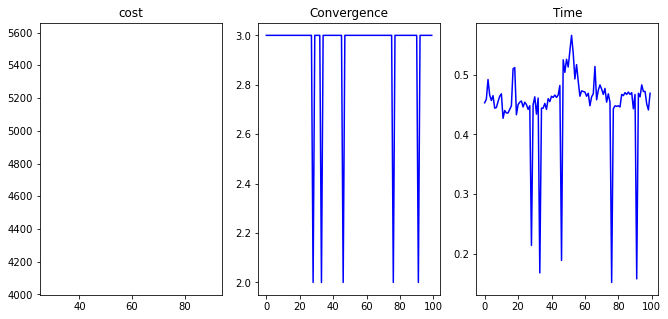

In [412]:
import time

lb = [2.6,0.7,17,7.3,7.3,2.9,5.0]
ub = [3.6,0.8,28,8.3,8.3,3.9,5.9]
nbTry=100
costT = []
convergeT = []
nbIterT = []
timeT = []
xoptT=[]
converge = False
for i in range(nbTry):
    start= time.time()
    xopt, fopt,converge, nbiter,objT = pso(JGh,lb,ub,debug=False,f_ieqcons= const)
    end = time.time()
    timeT.append(end-start)
    costT.append(fopt)
    convergeT.append(converge)
    nbIterT.append(nbiter)
    xoptT.append(xopt)
plotPSO2(nbTry,costT,convergeT,timeT,xoptT)


**The result is not good, none of the 100 test manage to find a solution that match the constraints**

As the search space is very complex, I decide to increase the swarmsize step by step to see if doing this the system start findind minimum solution.

In [414]:
import time

lb = [2.6,0.7,17,7.3,7.3,2.9,5.0]
ub = [3.6,0.8,28,8.3,8.3,3.9,5.9]
nbTry=10
swarmsize=100
for j in range(7):
    costT = []
    convergeT = []
    nbIterT = []
    timeT = []
    xoptT=[]
    converge = False
    for i in range(nbTry):
        start= time.time()
        xopt, fopt,converge, nbiter,objT = pso(JGh,lb,ub,debug=False,f_ieqcons= const,swarmsize = swarmsize)
        end = time.time()
        timeT.append(end-start)
        costT.append(fopt)
        convergeT.append(converge)
        nbIterT.append(nbiter)
        xoptT.append(xopt)
    print("# swarm : {3}, # cost < 5000 : {0} / {1}, min Cost : {2}, time = {4} ms" \
          .format(sum([ (x < 5000) for x in costT]),nbTry , round(min(costT),2),swarmsize,np.round(np.mean(timeT)*1000),4)) 
    swarmsize = swarmsize * 2

# swarm : 100, # cost < 5000 : 1 / 10, min Cost : 3372.67, time = 422.0 ms
# swarm : 200, # cost < 5000 : 2 / 10, min Cost : 3483.96, time = 834.0 ms
# swarm : 400, # cost < 5000 : 5 / 10, min Cost : 3232.18, time = 1196.0 ms
# swarm : 800, # cost < 5000 : 4 / 10, min Cost : 3209.85, time = 2135.0 ms
# swarm : 1600, # cost < 5000 : 6 / 10, min Cost : 3185.42, time = 4133.0 ms
# swarm : 3200, # cost < 5000 : 9 / 10, min Cost : 3152.57, time = 10418.0 ms
# swarm : 6400, # cost < 5000 : 10 / 10, min Cost : 3054.91, time = 19214.0 ms


We notice that the number of run that converge and the lowest cost value achieved improves when increasing the number of swarm. 

**As a compromise I choose to set the number of swarm to 5000**

The execution times are quit long with a high number of swarm and we are far from the optimal cost found with the gradient method (around 2994), so I start looking at the other parameters.

First I plot below the cost regardind the number of iteration. We can see that is is going quickly down and then the minimum seems not to change a lot. That means that if I increase the stop criterion, I won't modify to much the optimum but I will have quicker execution.

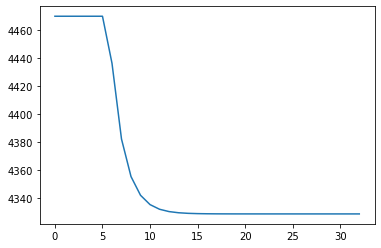

In [416]:
plt.plot(objT)
plt.show()

**So I try to run PSO (20 run) with swarm size = 5000, and stop croterion =1e-04 to see the result**

minimum cost 3052.4781715152726,  mean time exec : 12057.759535312653 ms 


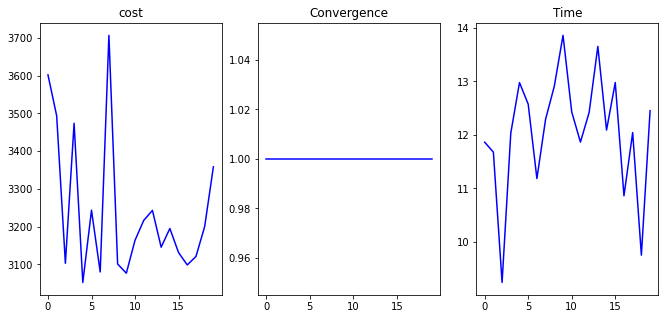

In [417]:
import time

lb = [2.6,0.7,17,7.3,7.3,2.9,5.0]
ub = [3.6,0.8,28,8.3,8.3,3.9,5.9]
nbTry=20
costT = []
convergeT = []
nbIterT = []
timeT = []
xoptT=[]
converge = False
for i in range(nbTry):
    start= time.time()
    xopt, fopt,converge, nbiter,objT = pso(JGh,lb,ub,debug=False,f_ieqcons= const,swarmsize=5000,minfunc=1e-04)
    end = time.time()
    timeT.append(end-start)
    costT.append(fopt)
    convergeT.append(converge)
    nbIterT.append(nbiter)
    xoptT.append(((xopt[0])**2+(xopt[1])**2)**(0.5))
plotPSO2(nbTry,costT,convergeT,timeT,xoptT)


**Result is really better and quicker ( 12s instead of around 15s with the previous stop criterion)**

But the cost found is still "high" regarding what I have found the gradient method.

So, the idea is to change the (phip,phig,omega) parameters to see which combinaison fit the better.

After several unitary test, the best solution are for a phip = 0, phig around 3 and not changing omega. (see below for the impact of phig).

In [420]:
import time

lb = [2.6,0.7,17,7.3,7.3,2.9,5.0]
ub = [3.6,0.8,28,8.3,8.3,3.9,5.9]
nbTry=5
swarmsize=5000
phip=0
phig=0.1
omega=0.5
for l in range(1):
    phip=0.1
    phig=0.1
    for k in range(8):
        phip=0.1
        for j in range(1):
            costT = []
            convergeT = []
            nbIterT = []
            timeT = []
            xoptT=[]
            converge = False
            for i in range(nbTry):
                start= time.time()
                xopt, fopt,converge, nbiter,objT = pso(JGh,lb,ub,debug=False,f_ieqcons= const,swarmsize = swarmsize, \
                phip=phip,phig=phig,omega=omega,minfunc=1e-04)
                end = time.time()
                timeT.append(end-start)
                costT.append(fopt)
                convergeT.append(converge)
                nbIterT.append(nbiter)
                xoptT.append(((xopt[0])**2+(xopt[1])**2)**(0.5))
            print("# phig : {3}, # cost < 5000 : {0} / {1}, min Cost : {2}, time = {4} ms".format\
                  (sum([ (x < 5000) for x in costT]),nbTry , round(min(costT),2), \
                                      phig,np.round(np.mean(timeT)*1000,5)))
            phip=phip+0.5
        phig=phig+0.5
    omega=omega+0.5

# phig : 0.1, # cost < 5000 : 5 / 5, min Cost : 3162.2, time = 8248.3264 ms
# phig : 0.6, # cost < 5000 : 5 / 5, min Cost : 3009.22, time = 13754.7893 ms
# phig : 1.1, # cost < 5000 : 5 / 5, min Cost : 2995.46, time = 17152.22507 ms
# phig : 1.6, # cost < 5000 : 5 / 5, min Cost : 2994.36, time = 18035.80637 ms
# phig : 2.1, # cost < 5000 : 5 / 5, min Cost : 2994.36, time = 14529.20017 ms
# phig : 2.6, # cost < 5000 : 5 / 5, min Cost : 2994.36, time = 17397.64872 ms
# phig : 3.1, # cost < 5000 : 5 / 5, min Cost : 2994.36, time = 20982.20224 ms
# phig : 3.6, # cost < 5000 : 5 / 5, min Cost : 2994.36, time = 22003.12743 ms


**My final step is :**

* to take the parameters that I have selected
* to run the PSO a high number of time
* to keep from all this runs the best result.

As the PSO algorythme is stochastic, running it a high number of time can lead to find better solutions

For 9 of this run, I plot the graph of cost regarding number of iteration.

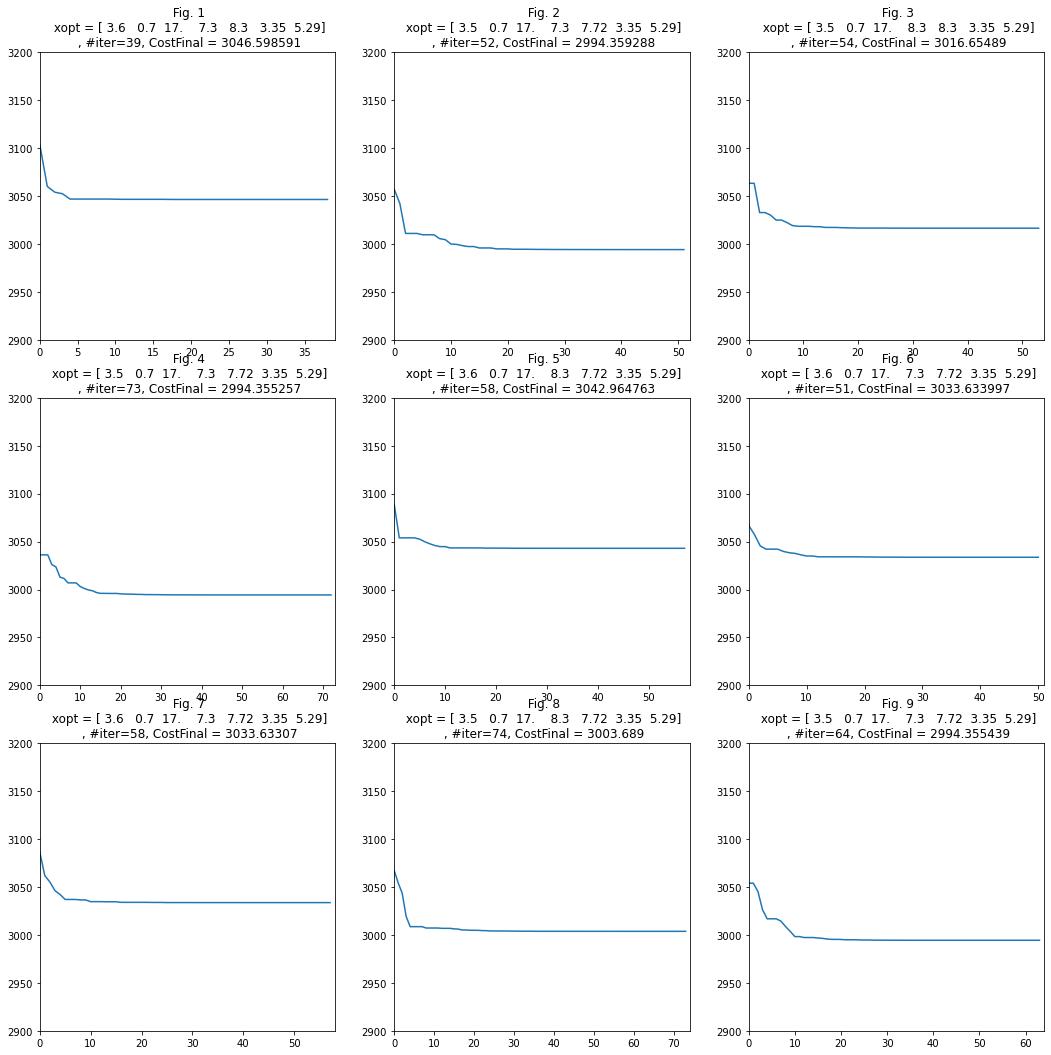

In [169]:
def see_ex3GResult(xOpt,JOpt, result,i,nbiter):
    title =  " Fig. " + str(i+1) + "\n xopt = " \
    + str(np.around(xOpt,2)) +"\n "+ ", #iter="+ str(nbiter) \
    +", CostFinal = " + str(np.around(JOpt,6))
    plt.subplot(3,3,i+1)
    plt.axis([0,len(result),2900,3200])
    plt.title(title)
    plt.plot(result)

lb = [2.6,0.7,17,7.3,7.3,2.9,5.0]
ub = [3.6,0.8,28,8.3,8.3,3.9,5.9]
nbTry=500
swarmsize=5000
phip=0
phig=3
omega=0.5
costT = []
convergeT = []
nbIterT = []
timeT = []
xoptT=[]
plt.figure(figsize=(18,18))
for i in range(nbTry):
    objT=[]
    start= time.time()
    xopt, fopt,converge, nbiter,objT = pso(JGh,lb,ub,debug=False,f_ieqcons= const,swarmsize = swarmsize, \
                phip=phip,phig=phig,omega=omega,minfunc=1e-04) 
    end = time.time()
    timeT.append(end-start)
    costT.append(fopt)
    convergeT.append(converge)
    nbIterT.append(nbiter)
    xoptT.append(xopt)
    if (i % (nbTry//8)) == 0:
        see_ex3GResult(xopt,fopt, objT,i // (nbTry//8),nbiter)


In [186]:
val, idx = min((val, idx) for (idx, val) in enumerate(costT))
print("Best solution found {0},\n\n with objective value {1} \
        and \n\n the constraint vector is {2}".format(xoptT[idx],val,-const(xoptT[idx])))

Best solution found [ 3.50000007  0.7        17.          7.3         7.71532274  3.35021473
  5.28665449],

 with objective value 2994.3551501857487         and 

 the constraint vector is [-7.39152978e-02 -1.97998542e-01 -4.99172288e-01 -9.04643802e-01
 -6.02331316e-08 -1.64440734e-08 -7.02500000e-01 -1.88235512e-08
 -5.83333325e-01 -5.13257397e-02 -3.62070699e-07]


**So for this run the best find solution has an objective value of 2994.3551501857487  and we can check that all the constraints are negatives. In previous test I reach at best an objective function of 2994.3550404629764 at position ( 3.5,0.7,17.,7.3,7.71532031,3.35021468,5.28665447)**

I finally found interesting to plot the different optimal cost found by the algorithm to show that it is as if there were several local minimum found.

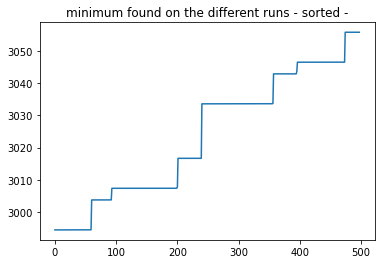

In [188]:
ScostT=sorted(costT)
plt.title("minimum found on the different runs - sorted -")
plt.plot(ScostT)
plt.show()

# General conclusion

## Banana function

### Dependance on initial design vector

Gradient method is very sensitive to the starting point for this function. Doing gradient method with fix step is I think impossible because of this.

This is a main advantage for this function for meta heuristic (PSO) since the algorithm compute several random starting points.

### Computational effort

For Gradient, depending on the starting point it varies from 11ms to 1530ms in my tests

For PSO, I have a final computational effort which was around 30ms with almost no deviation.

So with no surprise for this function, PSO is much quicker.

### Convergence history

For Gradient method, it depends a lot on the starting point

For PSO, the convergence is quick on all the tests a good approximation is reached after 10 iterations

### Frequency at which the technique gets trapped in local optimum
I do not found local optimum for this function

But for gradient optimal the algorithm was often block in the boundaries of the search universe.

## Eggcrate function

### Dependance on initial design vector

Gradient method is very sensitive to the starting point for this function. Because depending on the starting point, you will reach either a local minimum or a global minimum.

The PSO can have the same issue if the number of swarm is really too small. But In my tests with a swarmsize of 30 the system almost converges to the global optimal at each run.


### Computational effort

For Gradient, the algorithm is really quick : my tests gives an execution time in mean at 0.2ms (going up to 1ms maximum), but of course the optimal point is not found for each of these runs.

For PSO, I have a final computational effort which was around 10ms with almost no deviation.

So here gradient is quicker but often reach local minimum.

### Convergence history

For Gradient, my step criteria stop the iterations around 20 steps, but we can see on the graph that the convergence is already good after 5 to 7 iterations

For PSO, the convergence is quick on all the tests a good approximation is reached after 15 iterations

### Frequency at which the technique gets trapped in local optimum

The Frequency at which the technique gets trapped in local optimum is around 10% in my test.

As previously said with swarmsize = 30 the % of convergence on a local optimum is verys small


## Golinski' speed reducer

### Dependance on initial design vector

With the Uzawa methode I try several random start and the result has always been the same. It's a bit strange, but I do not find dependance on initial vector.

Same for PSO.

### Computational effort

For Uzawa methode the execution time is around 10s.

For PSO, I have an execution time between 10 and 15s for each run. To get my best solution I run the same algorithme 500 times. This means a cumulative time of approximatively 2 hours.

### Convergence history

For Uzawa the convergence at a good level needs around 15000 iterations

For PSO it is really less : around 10 or 20 iterations

At the end, even if the difference is very small, Uzawa found a smaller cost value.

### Frequency at which the technique gets trapped in local optimum

With the parameters that I have found, the Uzawa never get trapped in a local minimum

Whereas for PSO, the percentage was quit high (around 90%) perhaps due to parameters not completly fitted.


### Comparison with paper given with the assignment

I am a bit surprise that the cost values I found are smaller then the one in the paper (3004) and also better then the best one mention in the paper (2996 for Tapabrata Ray)

Same for this other paper (https://www.hindawi.com/journals/mpe/2013/419043/tab3/) where some better cost are found but with some constraint violation.

I perhaps miss something ?

## Larger, more complex design optimization problem

My feeling up to know is that each problem is different and it is not so easy to generalize. It seems to me that a good understanding of the "shape" of the universe (even if it is not easy on high dimension) help the choice and the tuning of the algorithm.